# Place cell model

# $P_{it} = e^{ \frac {d_{it}^2(1+\epsilon'_{it})^2} {r_i^2} \ln \alpha } + \epsilon_{it}$ 

Where:
* $P_{it}$ is the activation of place cell $i$ at time $t$
* $d_it$ is the distance between the rat's position at time $t$ and the center of PC $i$
* $r_i$ is the radius of place cell $i$
* $\alpha$ is the value of the place cells at their radius
* $\vec \epsilon'_{it}$ is the localization error of place cell $i$ at time $t$
* $\vec \epsilon_{it}$ models noise with constant intencity

NOTE: negative activations are set to 0

# IMPORTS AND FUNCTION DEFINITIONS

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
from numpy.linalg import norm
from itertools import combinations

from plotter import *
from plotnine import *
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn import BaseESN
# note: you must make this change in the easyesn code
# https://github.com/kalekiu/easyesn/issues/12
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp
import ipywidgets as widgets
from IPython.display import display, Markdown, Latex

%matplotlib inline


""" NOTES:
    This file provides mechanisms to:
    A) Data Processing
        1) Load trajectories from csv files ( file must contain columns 'x', 'y')
        2) Create a trajectory from a trajectory generator (see more documentation in respective function)
        3) Load a generator from a csv file
        4) Load a set of feeders from a csv file
        5) Generate a matrix of place cell activations (row=place cell, column=time_index) 
           pc activation computed according to following formula:
                 e^( log(K) * ||pos - pc_center||^2 / r^2  )
           where 
                r is the place cell's radius
                K is the place cell's activation value at the radius
    
    B) Plot data
        Imports functionalities from 'plotter.py' which uses library matplotlib
"""


# CONSTANTS
PC_VALUE_AT_RADIUS = 0.8  # 0.2 activation value (constant K in pc activation formula)


def list_files(folder, extension=""):
    """ lost all files in the folder with the given extension
    """
    return sorted([ f for f in os.listdir(folder) if f.endswith(extension)])

def pad_single_sequence(s, length):
    """ Pads a dataframe so that it has the given length.
        we expect len(s) < length, if so, the first element is repeated as necessary.
    """
    pad_vectors = [ s.loc[[0]] ] * (length - len(s))
    return pd.concat([* pad_vectors , s]).reset_index(drop=True)

def pad_all_sequences(sequences):
    """
        Pads all sequences so that they have the same number of elements.
        Padding is added by repeating the first element as necessary
    """
    longest = max([ len(s) for s in sequences.values() ])
    return { k : pad_single_sequence(s, longest) for k, s in sequences.items() }

def calculate_sequence_mean_displacement(sequence):
    """
        Calculates the mean distance between consecutive points in the sequence.
    """
    num_data = len(sequence)
    displacements = sequence.loc[0:(num_data-2)].reset_index(drop=True) - sequence.loc[1:(num_data-1)].reset_index(drop=True)    
    return norm(displacements, axis=1).mean()

def load_path(file_name):
    """" load csv fle specifying a path
         file must contain at least columns 'x' and 'y'
    """
    return pd.read_csv(file_name, delim_whitespace=True)
    # return sequence[['x', 'y']].to_numpy()


def load_generator(file_name):
    """" load csv fle specifying a path generator
             file must contain at least columns 'x', 'y' and 'steps'
        """
    return pd.read_csv(file_name, delim_whitespace=True)


def generate_path(generator):
    """ Generate a path using a generator
        'generator' is a pandas data frame containing at least 3 columns 'x' 'y' and 'steps'
        Column 'steps' indicate the number of step to reach the following way point (the
        value in the last row is ignored since it is the last point in the path)
    """

    # convert data to numpy arrays
    xy = generator[['x', 'y']].to_numpy()  # waypoints
    steps = generator['steps'].to_numpy()  #

    # interpolate each segment
    # endpoint=False will avoid repeating the last coordinate of each segment
    interpolator = lambda m_tuple: np.linspace(*m_tuple, endpoint=False)
    data = zip(xy[:-1], xy[1:], steps[:-1])
    path = np.concatenate(list(map(interpolator, data)) + [[xy[-1]]])
    return pd.DataFrame(path, columns=['x', 'y'])


def load_feeders(file_name):
    """"Function to load a set of feeders"""
    return pd.read_csv(file_name, delim_whitespace=True)[['x', 'y']]


def load_place_cells(file_name):
    """" Load csv fle specifying a set of place cells
         file must contain at least columns 'x', 'y' and 'placeradius'
    """
    return pd.read_csv(file_name, delim_whitespace=True)
    # return pcs[['x', 'y']].to_numpy(), pcs['placeradius'].to_numpy()


def calc_activation_matrix(path, pcs, localization_noise=0, percentual_noise = 0, additive_noise=0):
    """ Calculate a matrix containing the activation of all place cells for all times.
        Each row represents a place cell, while columns represent the time index.
        Both 'pos' and 'pcs' are data frames containing the path and the set of place cells.
    """
    # get number of pcs and position in path
    num_pcs = len(pcs)
    num_pos = len(path)

    # convert data to numpy to operate
    radii = pcs['placeradius'].to_numpy()
    pcs = pcs[['x', 'y']].to_numpy()
    pos = path[['x', 'y']].to_numpy()

    # replicate the position vector by the number of place cells for easy operations
    pos_tile = pos.reshape(1, -1, 2)
    pos_all = np.tile(pos_tile, (num_pcs, 1, 1))

    # replicate the place cells and radii by the number of positions for easy operations
    pcs_tile = pcs.reshape(-1, 1, 2)
    pcs_all = np.tile(pcs_tile, (1, num_pos, 1))
    radii_all = np.tile(radii.reshape((-1, 1)), (1, num_pos))

    # calculate the activations (see description of formula at the top of this file)
    delta = pos_all - pcs_all
    delta2 = (delta * delta).sum(2)
    
    if localization_noise != 0:
        d_error = np.random.uniform(1 - localization_noise, 1 + localization_noise, delta2.shape)
        delta2 *= d_error*d_error
    
    r2 = radii_all * radii_all
    exponents = np.log(PC_VALUE_AT_RADIUS) * delta2 / r2
    activations = np.exp(exponents)
    
    if percentual_noise != 0:
        activations *= np.random.uniform(1 - percentual_noise, 1 + percentual_noise, activations.shape)
        
    if additive_noise != 0:
        activations = np.minimum(np.maximum( 0, activations + np.random.uniform(-additive_noise, additive_noise, activations.shape)),1)
    return activations


def plot_paths_and_activations(pcs, sequence, activations, save_name, compare_sequence = None, title='', output_folder=''):
    """
        Creates figures with two subplots.
        Left plot shows heatmap representing the activation of the sequence vs time.
        Right plot shows the place cells in space, and the sequence path.
        If a compare sequence is given, the right plot also includes a second sequence to compare to
    """
    # create ouput folder if it doesnt exist:
    make_dirs(output_folder)
    
    fig, axs = plt.subplots(1, 2 )
    fig.suptitle(title)
    f1 = axs[0]
    f2 = axs[1]
    f2.autoscale(enable=True)
    f2.set_aspect('equal')
    plot_activation_matrix_heatmap(activations, plot=f1)

    plot_place_cells(pcs, plot=f2)  # add place cells to figure
#    plot_maze(plot=f2)
    if compare_sequence is not None:
        plot_path(compare_sequence, plot=f2)
    plot_path(sequence, plot=f2)
#    plot_feeders(feeders, plot=f2, s=80, zorder=2)  # zorder can be used to move the layer up or down
    plt.savefig(output_folder + save_name, dpi = 1200)
    
    return fig


def cos_sim(v1, v2):
    """
        Returns the cosine similitude between two vectors
    """
    return np.dot(v1, v2) / (norm(v1) * norm(v2))

# calculate the time series of cosine similitudes betweem input sequences and between reservoir state sequences
def all_cos_states(states1, states2):
    return [ cos_sim(s1, s2) for (s1, s2) in zip(states1, states2) ]


def create_and_train_reservoir(activations):
    """
        Creates and trains the reservoir network.
        Activation sequences is used as input and expected output of the network.
        Rows are expected to be place cells, while columns are expected to represent time indeces
    """
    
    # initialize random seed, and set reservoir dimensions
    np.random.seed(1)
    vectorDim = len(activations) # reservoir input dimension
    numNode = 400   # number of reservoir nodes

    # create training input and output sets, augment it 2^10 times: 
    inputDataTraining = activations.T 
    outputDataTraining = activations.T
    print('activation shape:', activations.shape) 
    print('input data shape:', inputDataTraining.shape)

    # augment data by concatenating 2^10 times
    inputDataTraining = np.concatenate( [ inputDataTraining ] * 1024, axis = 0 )
    outputDataTraining=inputDataTraining
    print('augmented data shape:', inputDataTraining.shape)

    # create and train network: 
    esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=0.05, regressionParameters=[1e-2], solver="lsqr", feedback=False)
    esn.fit(inputDataTraining, outputDataTraining, transientTime="Auto", verbose=1)
    return esn

def predict_reservoir(trained_reservoir, activations, continuation=False):
    """
        Uses the trained reservoir to predict using the activations as input
        Activations should be a matrix with rows indicating pcs and columns indicating time
        Resturns only the last few states
    """
    prediction, reservoirStatesBuffer = trained_reservoir.predict(activations.T, continuation=continuation)
    # print(reservoirStatesBuffer.shape)
    return prediction, reservoirStatesBuffer[257:,:].T

def plot_can_reservoir_distinguish_sequences( activations, states, integrators, input_similitudes, state_similitudes, integrator_similitudes, s1, s2, output_folder=''):
    """
        Generates a plot with 6 subplots
    """
    
    fig= plt.figure(figsize=(10,10))
    fig.suptitle(f'Sequences: {s1} VS {s2}')
    #fig.suptitle('State Trajectories', fontsize=16)
    #fig.suptitle('State Trajectories')

    plt.subplot(331)
    plt.title('Input Temporal Structure 1')
    #plt.plot( inputDataTesting[:76,:])
    #sns.heatmap(activations, cmap="seismic")
    sns.heatmap(activations[s1])
    #plt.ylim([-1.1,1])
    
    plt.subplot(334)
    plt.title('Input Temporal Structure 2')
    #plt.plot( inputDataTesting2[:76,:])
    #sns.heatmap(activations2, vmin=0.4, vmax=1)
    sns.heatmap(activations[s2])
    #plt.ylim([-1.1,1])
   


    plt.subplot(337)
    plt.title('Inputs Cosine Similarity')
    plt.plot( input_similitudes[s1][s2])
    plt.ylim([0,1.1])

    plt.subplot(338)
    plt.title('Reservoir States Cosine Similarity')
    plt.plot( state_similitudes[s1][s2])
    plt.ylim([0,1.1])
    
    plt.subplot(339)
    plt.title('Integrator States Cosine Similarity')
    plt.plot( integrator_similitudes[s1][s2])
    plt.ylim([0,1.1])


    # Following we plot the reservoir temporal structure, we can simplify printing only the first 10 states
    resn = 10
    plt.subplot(332)
    plt.title('Reservoir States Temporal Structure 1')
    plt.plot( states[s1][s1][:,:resn])
    #plt.plot( inputDataTestingA[:,:5])
    plt.ylim([-1.1,1])
    
    plt.subplot(335)
    plt.title('Reservoir States Temporal Structure 2')
    plt.plot( states[s1][s2][:,:resn])
    #plt.plot( inputDataTestingB[:,:5])
    plt.ylim([-1.1,1])
    
    
    resn = 256
    plt.subplot(333)
    plt.title('Integrator States Temporal Structure 1')
    plt.plot( integrators[s1][:,:resn])
    #plt.plot( inputDataTestingA[:,:5])
    # plt.ylim([-1.1,1])
    
    plt.subplot(336)
    plt.title('Integrator States Temporal Structure 2')
    plt.plot( integrators[s2][:,:resn])
    #plt.plot( inputDataTestingB[:,:5])
    # plt.ylim([-1.1,1])
    

    fig.tight_layout()
    plt.savefig(output_folder + f'reservoirstates-Y-simplified_{s1}_{s2}.png')
    return fig
     
    
def make_dirs(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
        
def create_empty_tabs(names):
    %matplotlib inline
    tabs = { n : widgets.Output() for n in names}
    tab_widget = widgets.Tab(children = list(tabs.values()))
    names = list(tabs.keys())
    for i in range(len(names)):
        tab_widget.set_title(i, names[i])
    display(tab_widget)
    return tabs
        
def create_or_add_to_tab_display(data, tab_widget=None):
    %matplotlib inline
    # get data to be displayed
    tab_names = list(data)
    tab_data = list(data.values())

    # if tab widget not yet created, create it:
    if tab_widget is None:
        tab_widget = widgets.Tab(children = [ widgets.Output() for t in tab_names ])
        for i in range(len(tab_names)):
            tab_widget.set_title(i, tab_names[i])
    
    for i in range(len(tab_names)):
        with tab_widget.children[i]:
            display(tab_data[i])
            
    return tab_widget       
        
def linear_integrator_states(data, past_coef, present_coef):
    result = np.zeros(data.shape)
    result[0] = data[0]
    for i in range(1,len(data)):
        result[i] = result[i-1]*past_coef + data[i]*present_coef
    return result

def constant_map(groups, value):
    return {g:value for g in groups}

def generate_cartesian_product_table( columns, data ):
    results = pd.DataFrame(columns=columns)
    
    num_rows = np.product([len(d) for d in data])
    repeat = num_rows
    for (c, d) in zip(columns, data):
        repeat /= len(d)
        d_repeated = np.repeat( d , repeat )
        results[c] = np.tile( d_repeated , num_rows // len(d_repeated) )
    return results

c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
Using Numpy backend.


# PREPROCESS ROBOT SEQUENCES

In [2]:
# INVERT AND STORE INVERTED ROBOT SEQUENCES
input_folder  = 'input/robot_recordings/' 
output_folder = 'input/robot_recordings/inverted/'
make_dirs(output_folder)
files = list_files(input_folder, '.csv')

def read_invert_save(input_folder, output_folder, file):
    data = pd.read_csv(input_folder + f)
    data2 = data.reindex(index=data.index[::-1]).reset_index(drop=True)
    data2.to_csv(output_folder + f, index=False)
    
for f in files:
    read_invert_save(input_folder, output_folder, f)
    

# LOAD SEQUENCES AND CALCULATE ACTIVATIONS

In [2]:
# FOLDERS 
folder_generators = 'input/'                           # folder where synthetic trajectory generators are stored
folder_recordings = 'input/robot_recordings/'          # folder where robot paths are stored
folder_inverted   = 'input/robot_recordings/inverted/' # folder where inverted robot paths are stored

# GLOBAL VARIABLES
paths = {} # dictionary of data frames representing paths
activations = {} # history of place cell activations for each path in 'paths'

# SYNTHETIC PATH GENERATOR FILES
y_a = 'path-y-a'
y_b = 'path-y-b'
syn_fss = 'syn-fss'
syn_sfs = 'syn-sfs'
syn_mmm = 'syn-mmm'

syn_fs_fs_fs = 'syn-fs-fs-fs'
syn_sf_sf_fs = 'syn-sf-sf-fs'
syn_mm_mm_mm = 'syn-mm-mm-mm'

# LOAD PLACE CELLS AND FEEDERS
pcs = load_place_cells('input/placecells.csv')
abcde = load_path('input/abcde.csv')
feeders = load_feeders('input/feeders.csv')


# LOAD AND GENERATE SYNTHETIC PATHS
synthetic_set1 = [ y_a, y_b ]
synthetic_set2 = [ syn_fss, syn_sfs, syn_mmm ]
synthetic_set3 = [ syn_fs_fs_fs, syn_sf_sf_fs, syn_mm_mm_mm]
paths.update({ f : generate_path(load_generator(folder_generators + f)) for f in synthetic_set1 + synthetic_set2 + synthetic_set3 })


# LOAD ROBOT PATHS
paths_robot = { f[-9:-4] : pd.read_csv(folder_recordings + f)[['x','y']].copy()  for f in list_files(folder_recordings, '.csv') }
paths_robot_inverted = { f'{f[-9:-4]}_inverted' : pd.read_csv(folder_inverted + f)[['x','y']].copy()  for f in list_files(folder_inverted, '.csv') }
padded = pad_all_sequences(paths_robot)
padded_inverted = pad_all_sequences(paths_robot_inverted)
paths.update( padded )
paths.update( padded_inverted  )


# CALCULATE AND PRINT MEAN DISTANCE BETWEEN SAMPLES IN ROBOT PATHS
robot_mean_distances = { k : calculate_sequence_mean_displacement(s) for k, s in paths_robot.items()} # need to use unpadded sequences, else averages extra zeros
display(Markdown('## Average distance between samples in robot paths:'))
display(robot_mean_distances)

# CALCULATE PC ACTIVATIONS FOR EACH PATH
activations.update({ k : calc_activation_matrix(p, pcs) for k, p in paths.items() })



# ADD NOISE TO ROBOT PC ACTIVATIONS



# DEFINE DATASETS (groups of sequences for different experiments)
data_sets = {
    'synthetic1' : synthetic_set1, 
    'synthetic2' : synthetic_set2, 
    'robot' : list(paths_robot.keys()),  
    'robot_inverted' : list(paths_robot_inverted.keys())
}



# PLOT PATHS AND ACTIVATIONS
display(Markdown('## Paths and activations (may take some time)...'))
save_folder = 'images/path_and_activations/'
figures_PA =  { k:plot_paths_and_activations(pcs, p, activations[k], f'path_and_activation_{k}.png', title = f'Sequence {k}', output_folder = save_folder) 
                for k, p in paths.items() }


# GENERATE PC SET TO INITIALIZE RESERVOIR NETWORKS:
reps = 15
initialization_set = np.concatenate([activations['syn-fss']]*reps, axis=1)

tab_widget = create_or_add_to_tab_display(figures_PA) # {y_a:f1, y_b:f2})

display(tab_widget)

## Average distance between samples in robot paths:

{'fss_0': 0.10172203909764774,
 'fss_1': 0.10024876655448742,
 'kkk_0': 0.1037335119470402,
 'kkk_1': 0.10272399158152683,
 'sfs_0': 0.10098300073848074,
 'sfs_1': 0.10472721395373853}

## Paths and activations (may take some time)...

## PLOT INTERACTIVE PATH POINTS

In [4]:
from plotnine import *
import pandas_bokeh
pandas_bokeh.output_notebook()

path_tabs = create_empty_tabs(paths)

for k, tab in path_tabs.items():
    with tab:
        # reset index dropping old values, then add new index column by resetting again
        path = paths[k].copy().reset_index(drop=True).reset_index()
        hover_string = '''<span style="font-size: 15px;"><b style="color:blue;">id:</b> $index &nbsp 
        <b style="color:blue;">(x,y):</b> ($x{0.000}, $y{0.000}) </span>
        '''
        
        path.plot_bokeh.scatter(x='x',y='y',id='index', hovertool_string=hover_string)
        display(path)


Loading BokehJS ...

# COMPARE SEQUENCES

In [5]:
# create and train reservoir network for each sequence:
display(Markdown(f'## Training {len(activations)} networks...'))
trained_networks = { k : create_and_train_reservoir(a) for k, a in activations.items() }

# create linear integrator for each sequence:
display(Markdown(f'## Calculating linear integrators...'))
linear_integrators = { k : linear_integrator_states(a.T, 0.95, 1.05) for k, a in activations.items() }

# DATA SETS: each sequence must be compared to all sequences in the same data set (we assume the data sets are disjoint)
comparison_data = { k : dset for _, dset in data_sets.items() for k in dset }

# predict using each reservoir (only predict sequences in same data set)
display(Markdown('### Predicting with each reservoir...'))
states = {  k1 :  { k2 : predict_reservoir(n, activations[k2], continuation=False)[1] for k2 in comparison_data[k1]} for k1, n in trained_networks.items()  }

# # PRINT DEBUG DATA
# print('networks:')
# display(trained_networks)
# print('state shapes:')
# display({ k : s.shape for k, s in reservoir_states_training_data.items() } )


display(Markdown('### Calculating cosine similitudes...'))
input_similitudes = { k1 : { k2 : all_cos_states(activations[k1].T, activations[k2].T) for k2 in comparison_data[k1] } for k1 in activations.keys()}
state_similitudes = { k1 : { k2 : all_cos_states(states[k1][k1], states[k1][k2]) for k2 in comparison_data[k1] } for k1 in activations.keys() }
l_int_similitudes = { k1 : { k2 : all_cos_states(linear_integrators[k1], linear_integrators[k2]) for k2 in comparison_data[k1] } for k1 in activations.keys()}
    
# DEBUG (toggle comment and indentation): 
# print cosine similitude at start of sequence
# cos_sim_states_0 = { k1 : { k2 : s[0] for k2, s in s_map.items() } for k1, s_map in cos_sim_states.items() }
# display(cos_sim_states_0)
# plt.plot(cos_sim_states['fss_0']['sfs_0'])
# plt.ylim([0,1.1])
            
display(Markdown('## Done'))

## Training 17 networks...

activation shape: (256, 96)
input data shape: (96, 256)
augmented data shape: (98304, 256)


100% (97883 of 97883) |##################| Elapsed Time: 0:00:18 Time:  0:00:18


activation shape: (256, 96)
input data shape: (96, 256)
augmented data shape: (98304, 256)


100% (97897 of 97897) |##################| Elapsed Time: 0:00:18 Time:  0:00:18


activation shape: (256, 23)
input data shape: (23, 256)
augmented data shape: (23552, 256)


100% (23133 of 23133) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 23)
input data shape: (23, 256)
augmented data shape: (23552, 256)


100% (23134 of 23134) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 23)
input data shape: (23, 256)
augmented data shape: (23552, 256)


100% (23133 of 23133) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24130 of 24130) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24137 of 24137) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24125 of 24125) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24125 of 24125) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24131 of 24131) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24129 of 24129) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24133 of 24133) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24138 of 24138) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24127 of 24127) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24128 of 24128) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24132 of 24132) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24130 of 24130) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


## Calculating linear integrators...

### Predicting with each reservoir...

### Calculating cosine similitudes...

## Done

# PLOT RESULTS

In [6]:
# PLOT ALL SEQUENCES
save_folder = 'images/'
display(Markdown(f'## Number of training sequences: {len(activations)}'))
for k1 in activations.keys():
    display(Markdown(f'## Training sequence: {k1}'))
    plots = {
        k2 :  plot_can_reservoir_distinguish_sequences( activations, states, linear_integrators, input_similitudes, state_similitudes, l_int_similitudes, k1, k2, save_folder)
        for k2 in comparison_data[k1]
    }
    display(create_or_add_to_tab_display(plots))
    

## Number of training sequences: 17

## Training sequence: path-y-a

## Training sequence: path-y-b

## Training sequence: syn-fss

## Training sequence: syn-sfs

## Training sequence: syn-mmm

## Training sequence: fss_0

## Training sequence: fss_1

## Training sequence: kkk_0

## Training sequence: kkk_1

## Training sequence: sfs_0

## Training sequence: sfs_1

## Training sequence: fss_0_inverted

## Training sequence: fss_1_inverted

## Training sequence: kkk_0_inverted

## Training sequence: kkk_1_inverted

## Training sequence: sfs_0_inverted

## Training sequence: sfs_1_inverted

# MIXED SELECTIVITY TESTING

### Prepare data for anova

In [7]:
# for each data set (synthetic paths and robot paths)
sample_states = {}
test_data_sets = ['synthetic2', 'robot' ]
algorithms = ['Reservoir', 'Interpolator']

time_index_map = {
    syn_fss : [4, 11, 18, 5, 12, 19],
    syn_sfs : [4, 11, 18, 5, 12, 19],
    syn_mmm : [4, 11, 18, 5, 12, 19],
    'fss_0' : [4, 11, 18],
    'fss_1' : [4, 11, 18],
    'sfs_0' : [4, 11, 18],
    'sfs_1' : [4, 11, 18],
    'kkk_0' : [4, 11, 18],
    'kkk_1' : [4, 11, 18],
}

for set_id in test_data_sets:  
    groups = data_sets[ set_id ]
    s1 = groups[0]
    
    # get slices of reservoir and integrator states
    state_data  = [
        np.concatenate([data[s2][time_index_map[s2],:] for s2 in groups])
        for data in [states[s1], linear_integrators]
    ]
    sample_states[set_id] = state_data
    
    # display debug data
    display(Markdown(f'## Data set: {set_id}'))
    display(f'Reservoir sample data shape: {state_data[0].shape}',
            f'Integrator sample data shape: {state_data[1].shape}')

# load template
data_template = pd.read_excel("test-data-template-3seq.xlsx")
display(Markdown('## Template'))
display(data_template)

## Data set: synthetic2

'Reservoir sample data shape: (18, 400)'

'Integrator sample data shape: (18, 256)'

## Data set: robot

'Reservoir sample data shape: (18, 400)'

'Integrator sample data shape: (18, 256)'

## Template

,subject,position,sequence,valye,speed
0,s1,ear,fss,0.3599,fast
1,s1,mid,fss,0.3975,slow
2,s1,late,fss,0.3278,slow
3,s2,ear,fss,0.2908,fast
4,s2,mid,fss,0.2844,slow
5,s2,late,fss,0.2907,slow
6,s1,ear,sfs,0.3724,slow
7,s1,mid,sfs,0.3582,fast
8,s1,late,sfs,0.2207,slow
9,s2,ear,sfs,0.2460,slow


## Debug code

In [8]:
# DEBUG CODE

neuron = 50
tab_names = [f'{k}-{a}' for k in test_data_sets for a in algorithms ]
tabs = create_empty_tabs(tab_names)

def fill_template(data):
    data_template['valye'] = data[:, neuron]
    return data_template.copy()

for set_id in test_data_sets:
    for d,a in zip([fill_template(s) for s in sample_states[set_id] ], algorithms):
        tab_name = f'{set_id}-{a}'
    
        with tabs[tab_name]:
            
            display(Markdown(f'# Data'), d)
            
            anova = pg.anova(dv='valye', between=['position', 'sequence'], data=d, detailed=True)
            display(Markdown(f'# Anova'), anova)
            
            rm_anova = pg.rm_anova(dv='valye', within=['position', 'speed'], subject='subject', data=d, detailed=True)
            display(Markdown(f'# Rm_anova'), rm_anova)
            
            sns.boxplot(hue="position", y="valye", x="sequence", data=d, palette="Set3")
            plt.show()

        

## Mixed selectivity test

In [9]:
# prepare tabs to display data 
tab_names = [f'{k}-{a}' for k in test_data_sets for a in algorithms ]
tabs = create_empty_tabs(tab_names)

# iterate data sets and algorithms
for set_id in test_data_sets:
    for set_states, a in zip(sample_states[set_id] , algorithms):
        tab_name = f'{set_id}-{a}'
        with tabs[tab_name]:
            
            # count cells for which
            sign = 0.001
            factor ='p-unc'#'p-GG-corr'#
            p_count= s_count = ps_count = 0 # count of positions with p-unc < sign
            
            # iterate each cell
            for neuron in range(set_states.shape[1]):
                
                # compare algorithm states for the different sequences using anova
                data_template['valye'] = set_states[:, neuron]
                # res = pg.rm_anova(dv='valye', within=['position', 'sequence'], subject='subject', data=data_template, detailed=True)
                res = pg.anova(dv='valye', between=['position', 'speed'], data=data_template, detailed=True)
                

                # count if position (early, mid, late) have different distributions
                if res.loc[0,factor] < sign:
                    p_count = p_count +1

                # count if sequence (fss, sfs, mmm) have different distributions
                if res.loc[1,factor] < sign:
                    s_count = s_count +1

                
                if res.loc[0,factor] < sign and res.loc[1,factor] < sign and np.mean(set_states[:,neuron]) > 0:
                    print("Two way main effect neuron: ", neuron)
                    
                # count if combined factors have different distribtions
                if res.loc[2,factor] < sign:
                    ps_count = ps_count +1

                    # plot state neuron if it has average positive activation:
                    if  np.mean(set_states[:,neuron]) > 0:
                        sns.boxplot(hue="position", y="valye", x="sequence", data=data_template, palette="Set3")
                        plt.title(f'Interaction neuron: {neuron}')
                        plt.show()
                        

                
        
            display(f'factor {factor}, sign {sign}')
            display(f'position effect    : {p_count}')       
            display(f'sequence effect    : {s_count}')       
            display(f'pos*seq interaction: {ps_count}')    

# PCA ANALYSIS

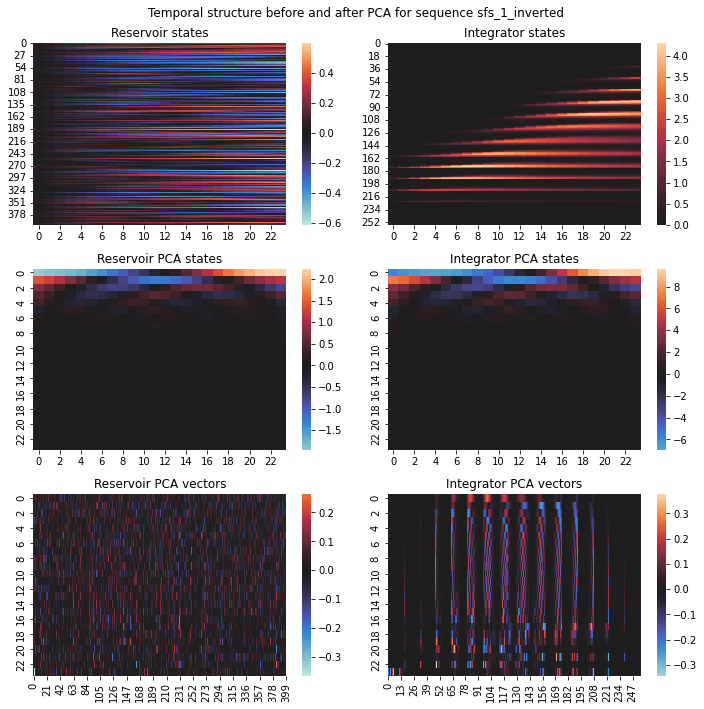

In [13]:
from sklearn.decomposition import PCA


# OBSERVATIONS: 
#     for reservoir states is a double map based on the training sequence and test sequence
#     for the linear integrator, there are no test sequences, only training sequences
# thus: to reduce one index in the reservoir states, we only consider a single train sequence per data set
train_set = {k : comparison_data[k][0] for k in paths} # for each test sequence, assign train set as first element in group
reservoir_states = { k : states[train_set[k]] [k] for k in paths }

# create map of algorithm to states
all_states = { 'Reservoir':reservoir_states, 'Integrator':linear_integrators }

# create function to process states to avoid repeating code
def process_data(data, function):
    return { algorithm : 
                { sequence : function(sequence_data) 
                  for sequence, sequence_data in algorithm_data.items() 
                } 
        for algorithm, algorithm_data in data.items()
    }

# PCA().fit(states['fss_0']['fss_0']).components_.shape



pca = process_data(all_states, lambda s : PCA().fit(s.copy()) )
variances = process_data(pca, lambda p : p.explained_variance_)

total_variances = process_data(variances, lambda v : v.sum())
percentual = process_data(variances, lambda v : v / v.sum())
accumulated = process_data(variances, lambda v : v.cumsum())
accumulated_percentual = process_data(percentual, lambda v : v.cumsum())

components = process_data(pca, lambda p : p.components_)
transformed = process_data(all_states, lambda s : PCA().fit_transform(s.copy()) )

def plot_pca_temporal_structure(reservoir_states, reservoir_pca_states, integrator_states, integrator_pca_states, r_components, i_components, sequence):
    %matplotlib inline
    fig= plt.figure(figsize=(10,10))
    fig.suptitle(f'Temporal structure before and after PCA for sequence {sequence}')
    
    plt.subplot(321)
    plt.title('Reservoir states')
    sns.heatmap(reservoir_states, center=0)
    
    plt.subplot(322)
    plt.title('Integrator states')
    sns.heatmap(integrator_states, center=0)
    
    plt.subplot(323)
    plt.title('Reservoir PCA states')
    sns.heatmap(reservoir_pca_states, center=0)
    
    plt.subplot(324)
    plt.title('Integrator PCA states')
    sns.heatmap(integrator_pca_states, center=0)
    
    plt.subplot(325)
    plt.title('Reservoir PCA vectors')
    sns.heatmap(r_components, center=0)
    
    plt.subplot(326)
    plt.title('Integrator PCA vectors')
    sns.heatmap(i_components, center=0)
    
    fig.tight_layout()
    return fig

pca_tabs = create_empty_tabs(paths)
for k, p in pca_tabs.items():
    with pca_tabs[k]:
        var_dfs = {a : pd.DataFrame({ 'variance': variances[a][k], 
                                   'percentual':percentual[a][k], 
                                   'accumulated':accumulated[a][k], 
                                   'accumulated_percentual':accumulated_percentual[a][k]
                                    }) 
                   for a in all_states
        }
        
        display(Markdown('## Numerical results of PCA'))
        display(pd.concat(var_dfs, axis=1))
        display(components['Reservoir'][k].shape)
        
        percentual_df = pd.DataFrame({ a : percentual[a][k] for a in all_states})
        accumulated_df = pd.DataFrame({ a : accumulated_percentual[a][k] for a in all_states})
        
        display(Markdown('## Variance per PCA component'))
        percentual_df.plot_bokeh.line()
        
        display(Markdown('## Accumulated variance'))
        accumulated_df.plot_bokeh.line()
        
        display(Markdown('## Temporal structure before and after PCA'))
        
        display(plot_pca_temporal_structure(reservoir_states[k].T, transformed['Reservoir'][k].T,
                                            linear_integrators[k].T, transformed['Integrator'][k].T, 
                                            components['Reservoir'][k], components['Integrator'][k],
                                            k))
        








# ROBOT CLASSIFICATION EXPERIMENT

## CLASSIFICATION RESULTS

In [3]:
experiment_results_file = 'results/eval_rats_15_tests_1/results_1642523202.4291527.csv'
results = pd.read_csv(experiment_results_file)
# display(results)

results_training = results.loc[results.stage == 'train']
results_testing  = results.loc[results.stage == 'test']

from sklearn.metrics import confusion_matrix
confussion = confusion_matrix(results_testing.ground_truth, results_testing.classification)

display(Markdown('### Confusion Matrix'))
display(confussion)

display(Markdown('### Distance between reservoir states of same sequence at decision point'))
display(f'Mean: {results_testing.nearest_distance.mean()}')
display(f'STD:  {results_testing.nearest_distance.std()}')

missclasified = results_testing.loc[results_testing.classification != results_testing.ground_truth]
display(Markdown('### Missclassified'))
display(missclasified)

display(Markdown('### Training Data'))
display(results_training)

display(Markdown('### Test Data'))
display(results_testing)




### Confusion Matrix

array([[15,  0],
       [ 1, 14]], dtype=int64)

### Distance between reservoir states of same sequence at decision point

'Mean: 0.9907847093639941'

'STD:  0.01987003215466516'

### Missclassified

,rat,seed,sequence_id,sequence_type,stage,classification,decision_time_index,nearest_id,nearest_distance,path_file,ground_truth
31,7,919560,31,fss,test,left,23,28,0.974154,results/eval_rats_15_tests_1/paths/path_164252...,right


### Training Data

,rat,seed,sequence_id,sequence_type,stage,classification,decision_time_index,nearest_id,nearest_distance,path_file,ground_truth
0,0,788275,0,sfs,train,none,9999,0,0.0,results/eval_rats_15_tests_1/paths/path_164252...,left
1,0,788275,1,fss,train,none,9999,1,0.0,results/eval_rats_15_tests_1/paths/path_164252...,right
4,1,19514,4,sfs,train,none,9999,4,0.0,results/eval_rats_15_tests_1/paths/path_164252...,left
5,1,19514,5,fss,train,none,9999,5,0.0,results/eval_rats_15_tests_1/paths/path_164252...,right
8,2,615930,8,sfs,train,none,9999,8,0.0,results/eval_rats_15_tests_1/paths/path_164252...,left
9,2,615930,9,fss,train,none,9999,9,0.0,results/eval_rats_15_tests_1/paths/path_164252...,right
12,3,234944,12,sfs,train,none,9999,12,0.0,results/eval_rats_15_tests_1/paths/path_164252...,left
13,3,234944,13,fss,train,none,9999,13,0.0,results/eval_rats_15_tests_1/paths/path_164252...,right
16,4,942231,16,sfs,train,none,9999,16,0.0,results/eval_rats_15_tests_1/paths/path_164252...,left
17,4,942231,17,fss,train,none,9999,17,0.0,results/eval_rats_15_tests_1/paths/path_164252...,right


### Test Data

,rat,seed,sequence_id,sequence_type,stage,classification,decision_time_index,nearest_id,nearest_distance,path_file,ground_truth
2,0,788275,2,sfs,test,left,23,0,0.995233,results/eval_rats_15_tests_1/paths/path_164252...,left
3,0,788275,3,fss,test,right,29,1,0.970282,results/eval_rats_15_tests_1/paths/path_164252...,right
6,1,19514,6,sfs,test,left,25,4,0.998648,results/eval_rats_15_tests_1/paths/path_164252...,left
7,1,19514,7,fss,test,right,26,5,0.997685,results/eval_rats_15_tests_1/paths/path_164252...,right
10,2,615930,10,sfs,test,left,25,8,0.998252,results/eval_rats_15_tests_1/paths/path_164252...,left
11,2,615930,11,fss,test,right,25,9,0.993239,results/eval_rats_15_tests_1/paths/path_164252...,right
14,3,234944,14,sfs,test,left,25,12,0.997286,results/eval_rats_15_tests_1/paths/path_164252...,left
15,3,234944,15,fss,test,right,71,13,0.893991,results/eval_rats_15_tests_1/paths/path_164252...,right
18,4,942231,18,sfs,test,left,23,16,0.993083,results/eval_rats_15_tests_1/paths/path_164252...,left
19,4,942231,19,fss,test,right,24,17,0.998683,results/eval_rats_15_tests_1/paths/path_164252...,right


## Plot robot paths

In [4]:
from plotnine import *
import pandas_bokeh
pandas_bokeh.output_notebook()
from bokeh.models import Range1d



experiment_paths = { f'Rat {r}' : {} for r in results.rat.unique()}
for s_id, row in results.iterrows():
    experiment_paths[f'Rat {row["rat"]}'][f'{row["stage"]} {row["sequence_type"]}'] = pd.read_csv(row["path_file"])
# display(experiment_paths)

# experiment_paths = {f'Rat {row["rat"]} {row["stage"]} {row["sequence_type"]}' : pd.read_csv(row["path_file"]) for index, row in results.iterrows()}
# # display(experiment_paths)

rat_tabs = create_empty_tabs(experiment_paths)

for k, r_tab in rat_tabs.items():
    with r_tab:
        rat_paths = experiment_paths[k]
        path_tabs = create_empty_tabs(rat_paths)
        
        for k2, p_tab in path_tabs.items():
            with p_tab:
            
                # reset index dropping old values, then add new index column by resetting again
                path = rat_paths[k2].copy().reset_index(drop=True).reset_index()
                hover_string = '''<span style="font-size: 15px;"><b style="color:blue;">id:</b> $index &nbsp 
                <b style="color:blue;">(x,y):</b> ($x{0.000}, $y{0.000}) </span>
                '''
                fig = path.plot_bokeh.scatter(x='x',y='y',id='index', hovertool_string=hover_string)
                fig.x_range=Range1d(-0.5, 0.5)
                fig.y_range=Range1d(-1.5, 1.5 )
                display(path)


Loading BokehJS ...

## Durtion statistics

### Decision time boxplot

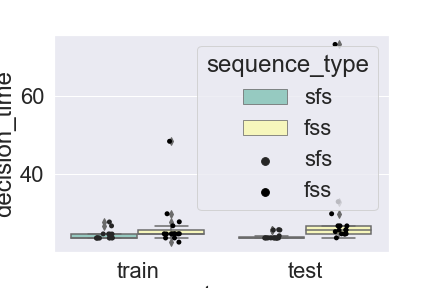

### Anova

,Source,SS,DF,MS,F,p-unc,np2
0,sequence_type,215.296877,1,215.296877,4.464490,0.039077,0.073837
1,stage,21.753610,1,21.753610,0.451092,0.504578,0.007991
2,sequence_type * stage,34.049510,1,34.049510,0.706066,0.404326,0.012451
3,Residual,2700.560341,56,48.224292,NaN,NaN,NaN


### DATA

,stage,sequence_type,total_time,decision_time
0,train,sfs,23.650691,23.650691
1,train,fss,22.583274,22.583274
2,test,sfs,28.774046,23.670110
3,test,fss,38.047810,29.823938
4,train,sfs,23.653170,23.653170
5,train,fss,24.709621,24.709621
6,test,sfs,31.792568,25.679514
7,test,fss,49.344523,26.726172
8,train,sfs,27.733850,27.733850
9,train,fss,23.657799,23.657799


In [5]:
def get_total_time(row):
    return pd.read_csv(row['path_file']).t.iloc[-1]

def get_decision_time(row):
    index = row['decision_time_index']
    return pd.read_csv(row['path_file']).t.iloc[ index if index < 9999 else -1]

results['total_time'] = results.apply(get_total_time, axis=1)
results['decision_time'] = results.apply(get_decision_time, axis=1)


display(Markdown("### Decision time boxplot"))
%matplotlib widget
# results.boxplot(column="decision_time", by="sequence_type")
sns.set(font_scale = 2)
sns.boxplot(y="decision_time", x="stage", data=results, hue="sequence_type", palette="Set3")
sns.stripplot(y="decision_time", x="stage", data=results, hue="sequence_type", color = 'black', dodge = True)

plt.show()

anova = pg.anova(dv='decision_time', between=['sequence_type','stage'], data=results, detailed=True)
display(Markdown(f'### Anova'), anova)


display(Markdown("### DATA"))
display(results[['stage','sequence_type','total_time','decision_time']])





## Duration statistics after filtering paths

### Decision time boxplot

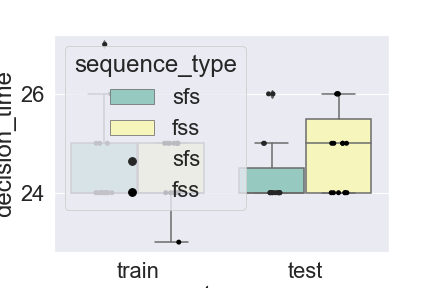

### Anova

,Source,SS,DF,MS,F,p-unc,np2
0,sequence_type,0.416667,1,0.416667,0.673077,0.415460,0.011876
1,stage,0.416667,1,0.416667,0.673077,0.415460,0.011876
2,sequence_type * stage,1.350000,1,1.350000,2.180769,0.145346,0.037483
3,Residual,34.666667,56,0.619048,NaN,NaN,NaN


## DEBUG

### Decition times

,sfs_train,fss_train,sfs_test,fss_test
rat,,,,
0,24,23,24,24
1,24,24,26,26
2,26,24,25,25
3,24,24,26,24
4,25,25,24,24
5,24,24,24,25
6,25,25,24,24
7,27,25,24,24
8,24,25,24,26


### Decision time reorganized

,sfs,fss,train,test
0,24,23,24,24
1,24,24,24,26
2,26,24,26,25
3,24,24,24,26
4,25,25,25,24
5,24,24,24,24
6,25,25,25,24
7,27,25,27,24
8,24,25,24,24
9,24,25,24,24


### Averages

sfs      24.466667
fss      24.633333
train    24.466667
test     24.633333
dtype: float64

In [6]:
def filter_path_to_decision_point(row):
    # read path
    path = pd.read_csv(row['path_file'])[['x','y']]

    # find length until decision point
    elements = row['decision_time_index'] + 1
    if elements > 500:
        elements = len(path)
        
    # filter points where it was stuck
    filtered = [path.loc[0]]
    for i,xy in path.loc[1:(elements-1)].iterrows():
        if math.sqrt(((xy - filtered[-1])**2 ).sum()) > 0.02:
            filtered += [xy]
    return pd.DataFrame(columns = ['x','y'], data = filtered)

def new_length(row):
    return len(filter_path_to_decision_point(row))


results['decision_time'] = results.apply(new_length, axis=1)


display(Markdown("### Decision time boxplot"))
%matplotlib widget
# results.boxplot(column="decision_time", by="sequence_type")
sns.set(font_scale = 2)
sns.boxplot(y="decision_time", x="stage", data=results, hue="sequence_type", palette="Set3")
sns.stripplot(y="decision_time", x="stage", data=results, hue="sequence_type", color = 'black', dodge = True)

plt.show()


anova = pg.anova(dv='decision_time', between=['sequence_type','stage'], data=results.copy().reset_index(drop=True), detailed=True)
display(Markdown(f'### Anova'), anova)

# display(Markdown("### DATA"))
# display(results)




##################################################################################################
## DEBUG - CREATE TABLE OF DECISION TIMES FOR EACH RAT, COLUMNS ARE THE SEQUENCES AND STAGES
display(Markdown('## DEBUG'))

sfs_train = results.decision_time.loc[ (results.sequence_type == 'sfs') & (results.stage == 'train')].copy().reset_index(drop=True)
fss_train = results.decision_time.loc[ (results.sequence_type == 'fss') & (results.stage == 'train')].copy().reset_index(drop=True)
sfs_test = results.decision_time.loc[ (results.sequence_type == 'sfs') & (results.stage == 'test')].copy().reset_index(drop=True)
fss_test = results.decision_time.loc[ (results.sequence_type == 'fss') & (results.stage == 'test')].copy().reset_index(drop=True)
decision_time_table = pd.DataFrame({'sfs_train':sfs_train, 'fss_train':fss_train, 'sfs_test':sfs_test, 'fss_test':fss_test})
decision_time_table.index.name = 'rat'

decision_table_combined = pd.DataFrame({'sfs'  : pd.concat([sfs_train, sfs_test ]).reset_index(drop=True), 
                                        'fss'  : pd.concat([fss_train, fss_test ]).reset_index(drop=True),
                                        'train': pd.concat([sfs_train, fss_train]).reset_index(drop=True),
                                        'test' : pd.concat([sfs_test,  fss_test ]).reset_index(drop=True)})

display(Markdown('### Decition times'),decision_time_table)
display(Markdown('### Decision time reorganized'),decision_table_combined)

display(Markdown('### Averages'), decision_table_combined.mean())

# # def variance
# total_mean = results.decision_time.mean()
# individual_group_means = decision_time_table.mean()
# combined_group_means = decision_table_combined.mean()

# def my_anova(data):
#     melted_data = data.melt()
    
#     # display(data)
#     # display(melted_data)
    
#     group_means = data.mean()
#     total_mean = melted_data.value.mean()
    
#     display(data)
#     display(group_means)
    
#     ss_total = melted_data.value.var()*(len(melted_data)-1)
#     display(len(data))
#     ss_effect = group_means.var() * (len(group_means)-1) * len(data)
#     ss_error = (data.var()*(len(data)-1)).sum()
    
#     # ms_effect =ss_effect / 
    
#     return pd.DataFrame( columns = ['ss_total', 'ss_effect', 'ss_error', 'np2'], 
#                            data=[[ss_total, ss_effect, ss_error, ss_effect / ss_error ]])

    

# anova_results = pd.concat({ 'sequence_type' : my_anova(decision_table_combined[['sfs','fss']]),
# 'stage': my_anova(decision_table_combined[['train','test']]),
# 'both': my_anova(decision_time_table) })
# # anova_results = anova_results.drop(anova_results.columns[0], axis=1)
# display(anova_results)

        

## Reclassifying sequences after filtering

### Classification

In [123]:
from sklearn.metrics import confusion_matrix
folder_noise = 'images/noise/'


def associate_action(s):
    return 'left' if s == 'sfs' else 'right'


def calculate_reservoir_state( row , pcs, localization_noise, percentual_noise, additive_noise):
    # display(f'Creating reservoir {row["sequence_id"]}')
    
    # NOTE: the reservoir must be the first thing created after choosing the seed
    # otherwise supposedly identical reservoirs will be different when noise is used.
    np.random.seed(row['seed'])
    reservoir = PredictionESN(n_input=256, n_output=1, n_reservoir=400, 
                    leakingRate=0.05, regressionParameters=[1e-2], solver="lsqr", feedback=False)
    reservoir.propagate(initialization_set.T) # move reservoir state away from 0 set
    
    np.random.seed(row['noise_seed'])
    path = filter_path_to_decision_point(row)
    activations = calc_activation_matrix(path, pcs, localization_noise, percentual_noise, additive_noise)
    
    return  reservoir.propagate(activations.T)[257:,-1].T

def replicate_data(result_table, replications, seed):
    save_state = np.random.get_state()
    np.random.seed(seed)
    
    reps = result_table.copy()
    reps = pd.concat([reps]*replications).reset_index()
    reps = reps.rename(columns={'index':'path_id'})
    
    reps.seed = np.repeat(np.random.randint(0, 32000, int(len(reps)/4)), 4)
    reps['noise_seed'] = np.random.randint(0, 32000, len(reps))
    reps.rat = np.repeat(np.arange(int(len(reps)/4)),4)
    reps.sequence_id = np.arange(len(reps))
    
    np.random.set_state(save_state)
    return reps

def classify(result_table, seed, pcs, replications, localization_noise, percentual_noise, additive_noise):
    result_table = replicate_data(result_table, replications, seed)
    
    all_states = { index : calculate_reservoir_state(row, pcs, localization_noise, percentual_noise, additive_noise) 
                       for index, row in result_table.iterrows()
                 } 

    
    same_class_distances = []
    different_class_distances = []
    for rat, experiment_data in  result_table.groupby(['rat']):
        train_sequences = experiment_data.loc[ experiment_data.stage == 'train' ]
        test_sequences = experiment_data.loc[ experiment_data.stage == 'test' ]

        for id_test, s_test in test_sequences.iterrows():        
            # find distances to train sequences, then classify according to nearest neighbor
            distances = { id_train : cos_sim(all_states[id_test], all_states[id_train]) for id_train, _ in train_sequences.iterrows() }
            max_arg = max(distances, key=distances.get)
            s_class = result_table.sequence_type[max_arg]

            for id_train, s_train in train_sequences.iterrows():
                d = distances[id_train]
                d_array = same_class_distances if s_test['ground_truth'] == s_train['ground_truth'] \
                        else different_class_distances
                d_array.append(d)

            result_table.loc[id_test,'nearest_id'] = max_arg
            result_table.loc[id_test,'nearest_distance'] = distances[max_arg]
            result_table.loc[id_test,'classification'] = associate_action(s_class)
            
    return result_table, same_class_distances, different_class_distances

def printConfusionMatrix(results):
    training = results.loc[results.stage == 'train']
    testing  = results.loc[results.stage == 'test']
    accuracy = float( sum(testing.classification == testing.ground_truth) / len(testing) )
    confussion = confusion_matrix(training.ground_truth, testing.classification)
    display(Markdown(f'### Accuracy: {accuracy}'))
    display(Markdown('### Confusion Matrix'))
    display(confussion)
    return confussion, accuracy

def distance_statistics(same_d, different_d):
    display(Markdown('### Statistics of distances between reservoir states'))
    
    display(Markdown('#### DF description'))
    display(pd.DataFrame({'same_class':same_d, 'different_class':different_d}).describe())

    display(Markdown('#### Ttest (uncorrelated):'), pg.ttest(same_d, different_d, paired = False))
    display(Markdown('#### Ttest (correlated):'), pg.ttest(same_d, different_d, paired = True))

    # plotting distributions
    classes = ['Same']*len(same_d) + ['Different']*len(different_d)
    distance_df = pd.DataFrame({'classes':classes, 'distance':same_d + different_d})
    fig= plt.figure(figsize=(10,10))
    sns.set(font_scale = 1.5)
    plt.clf()
    p = sns.boxplot(y="distance", x="classes", data=distance_df, palette="Set3")
    p.set_ylabel("cosine similarity")
    plt.show()


def show_noise(row, palce_cells, localization_noise, percentual_noise, additive_noise, save_folder = None):
    
    np.random.seed(row['seed'])
    reservoir = PredictionESN(n_input=256, n_output=1, n_reservoir=400, leakingRate=0.05, regressionParameters=[1e-2], solver="lsqr", feedback=False)
    path = filter_path_to_decision_point(row)
    np.random.seed(row['noise_seed'])
    activations = calc_activation_matrix(path, pcs, localization_noise, percentual_noise, additive_noise)
    r_states = reservoir.propagate(activations.T)[257:,].T
    
    fig= plt.figure(figsize=(10,10))
    plt.title(f'Localization: {localization_noise} - Percentual: {percentual_noise} Additive: {additive_noise}')
    
    sns.heatmap(activations, vmin=0, vmax=1)
    fig.tight_layout()
    if save_folder is not None:
        plt.savefig(save_folder + f'noise_levels-R{row["sequence_id"]}-L{localization_noise}_A{additive_noise}.png')
    return fig, activations, r_states
    
    
    
# GET PLACE CELLS AND FILTER PATHS
palce_cells = load_place_cells('input/placecells.csv')


# CHOOSE NOISE PARAMETERS:
# NOTE: we will only use additive and localization error
replications = 8
localization_noise = 0.
percentual_noise = 0.
additive_noise = 0.4

nrange = 5
localization_errors = {f'L {0.1*i:0.1f}':0.1*i for i in range(nrange) }
additive_errors = {f'A {0.1*i:0.1f}':0.1*i for i in range(nrange) }
np.random.seed(0)
seeds = np.random.randint(0,32000, nrange*nrange)
next_id = 0


 # = {f'{0.1*i:.1f}--{0.1*j:.1f}':(0.1*i, 0.1*j)  for i in range(6) for j in range(6)}
loclization_tabs = create_empty_tabs(localization_errors)
folder_noise_levels = folder_noise + 'levels/'
make_dirs(folder_noise_levels)
noise_results = pd.DataFrame(columns=['Localization Noise','Additive Noise', 'seed', 'Accuracy', 'Same class distances', 'Different class distances', 'sample activations'])

for k1, l_tab in loclization_tabs.items():
    with l_tab:
        localization_noise = localization_errors[k1]
        
        additive_tabs = create_empty_tabs(additive_errors)
        for k2, a_tab in additive_tabs.items():
            with a_tab:
                s = seeds[next_id]
                additive_noise = additive_errors[k2]
                
                # localization_noise , additive_noise = noise_sets[k]
                classification_results, same_d, different_d = classify(results, s, palce_cells, replications, localization_noise, percentual_noise, additive_noise)
                confussion, accuracy = printConfusionMatrix(classification_results)
                distance_statistics(same_d, different_d)
                fig, activations, states = show_noise(classification_results.loc[0],palce_cells, localization_noise, percentual_noise, additive_noise,folder_noise_levels)
                display(fig)
                plt.close(fig)
                
                noise_results.loc[len(noise_results.index)] = [localization_noise, additive_noise, s, accuracy, same_d, different_d, activations] 
                s+=1
                

# save results so that they don't have to be calculated each time      
noise_results['Localization Noise'] = noise_results['Localization Noise'].apply(lambda x: f'{x:.1f}')
noise_results['Additive Noise'] = noise_results['Additive Noise'].apply(lambda x: f'{x:.1f}')
noise_results.to_pickle('noise_results.pickle')
     


# pd.set_option("display.max_rows", None)
# display(same_class_distances)
# display(different_class_distances)
# display(results_filtered)
# pd.set_option("display.max_rows", 10)

### Show table of noise

'Loading noise results from disk'

c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\Users\bucef\AppData\Local\Temp/ipykernel_21788/954272026.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


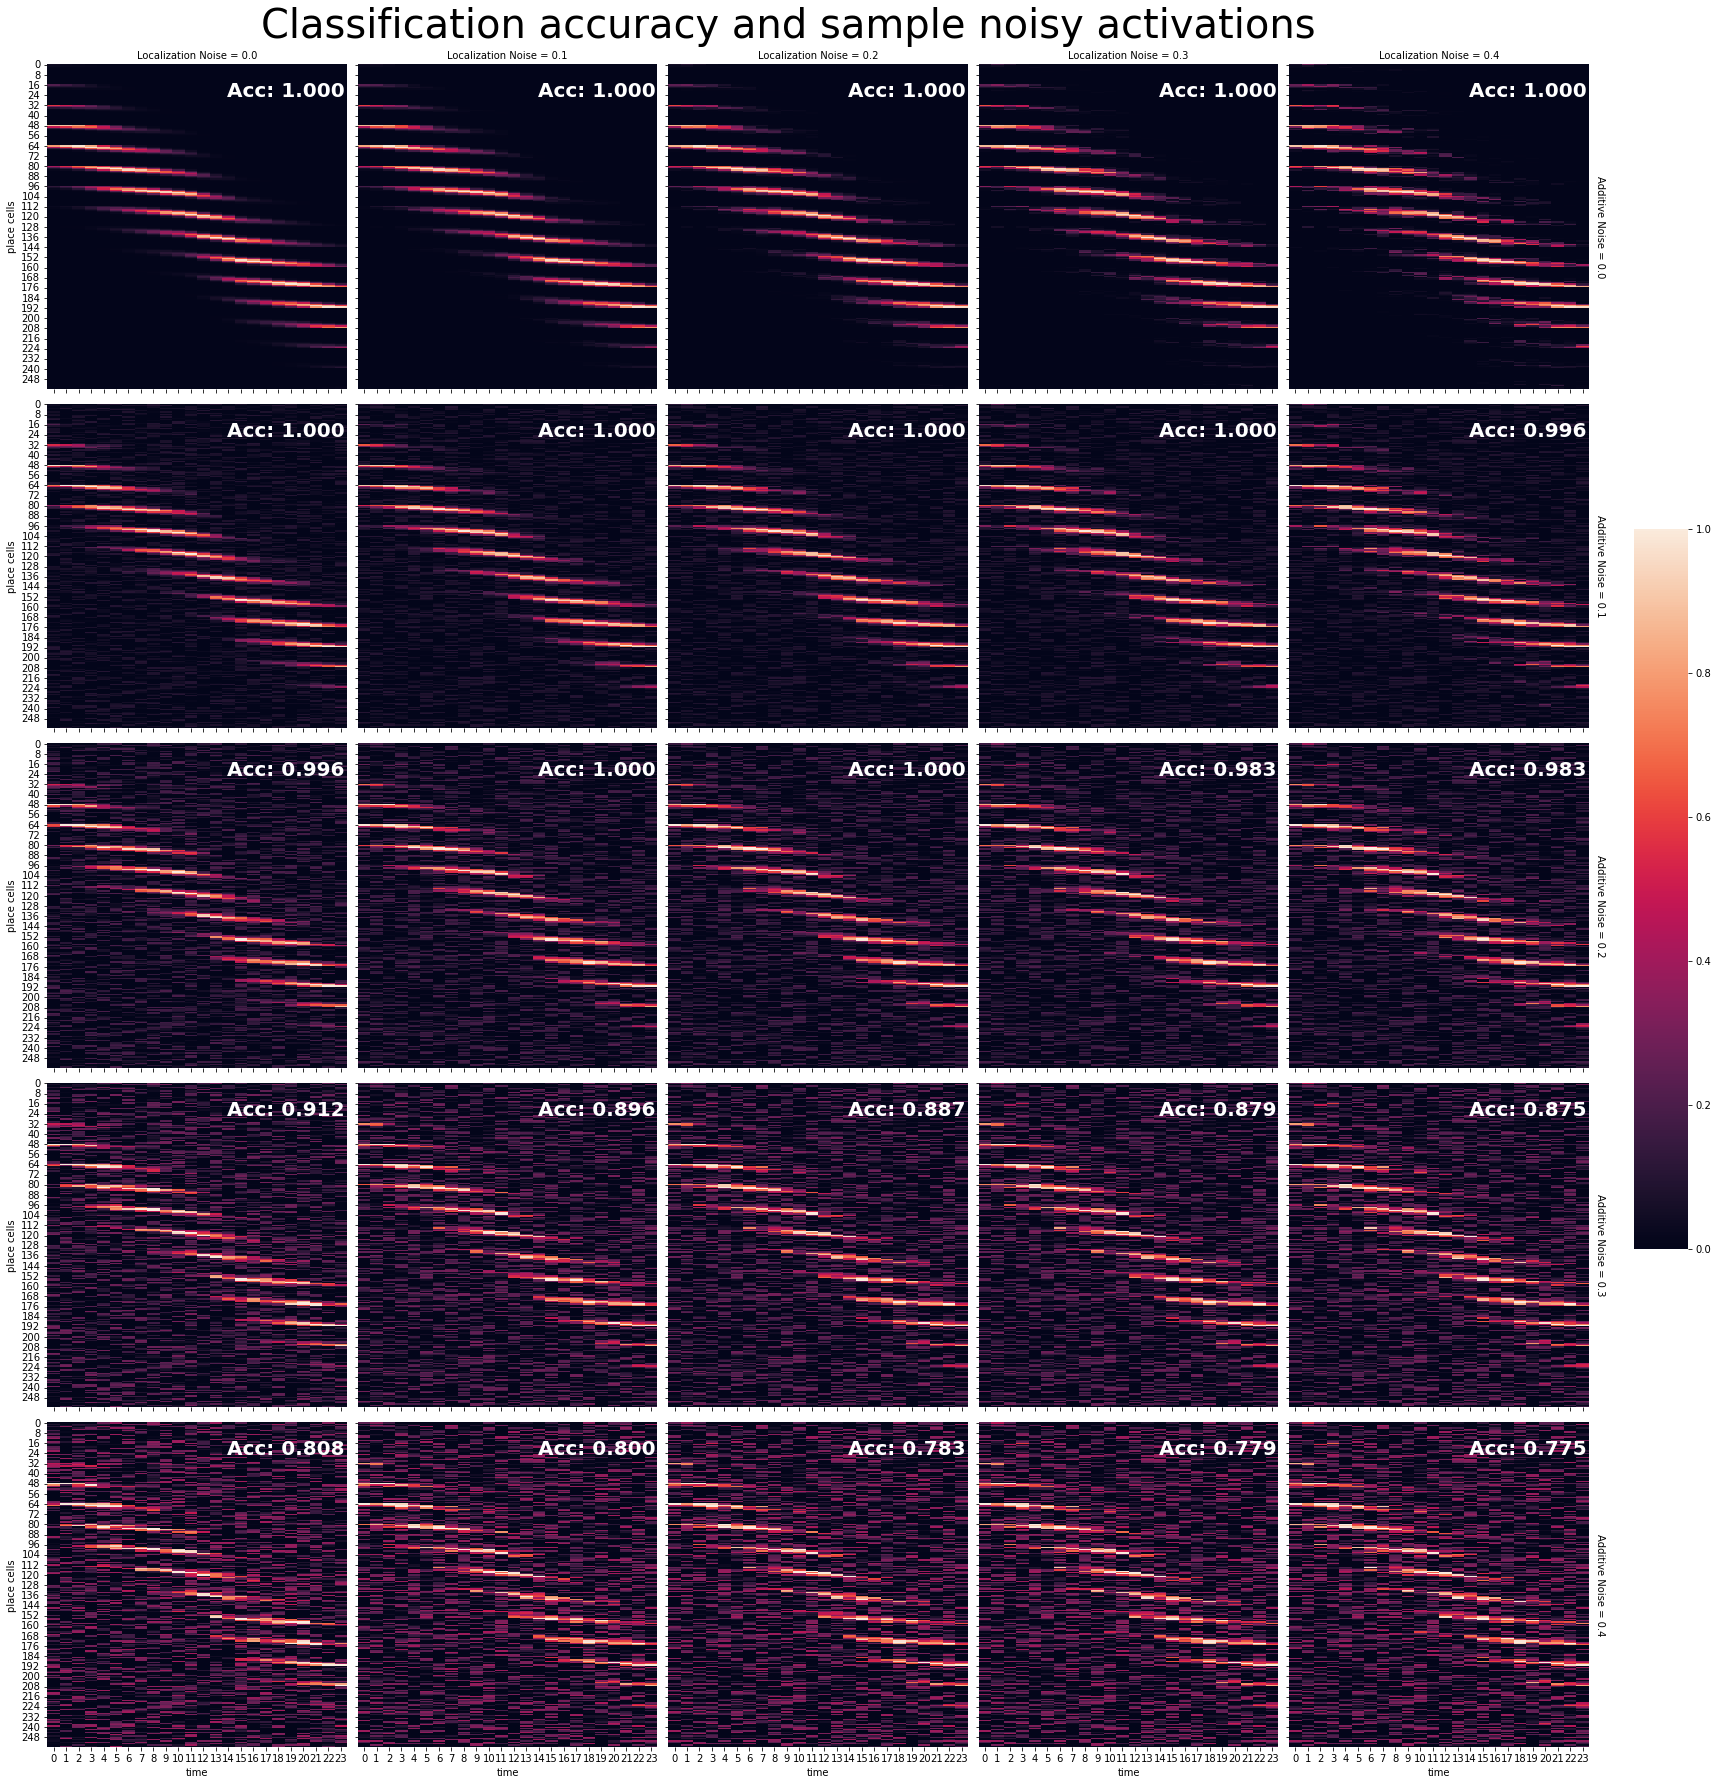

In [2]:
folder_noise = 'images/noise/'
#noise_results = None # uncomment to load results from disk
if 'noise_results' not in locals() and 'noise_results' not in globals() and os.path.exists('noise_results.pickle'):
    display('Loading noise results from disk')
    noise_results = pd.read_pickle('noise_results.pickle')
# display(noise_results)


fig_size = 5
g = sns.FacetGrid(noise_results, col="Localization Noise", row="Additive Noise", margin_titles=True, height=fig_size, aspect=1)
cbar_ax = g.fig.add_axes([.91, .3, .03, .4])
def heatmap_plot(x, y, **kwargs):
    k = x.index[0]
    axes = sns.heatmap(x.iloc[0], vmin=0, vmax=1, cbar=k == 0, cbar_ax=None if k else cbar_ax)
    axes.text(0.6, 0.9, f'Acc: {y.iloc[0]:0.3f}', transform=axes.transAxes, size=20, weight='bold', color='white')
g.map(heatmap_plot, 'sample activations', 'Accuracy')
g.fig.suptitle('Classification accuracy and sample noisy activations', fontsize=40, x=0.44, y=0.99)
g.set_xlabels("time")
g.set_ylabels("place cells")
g.fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig(folder_noise + f'sample_noise_table.png')


### Plot table of distance boxplots

c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.


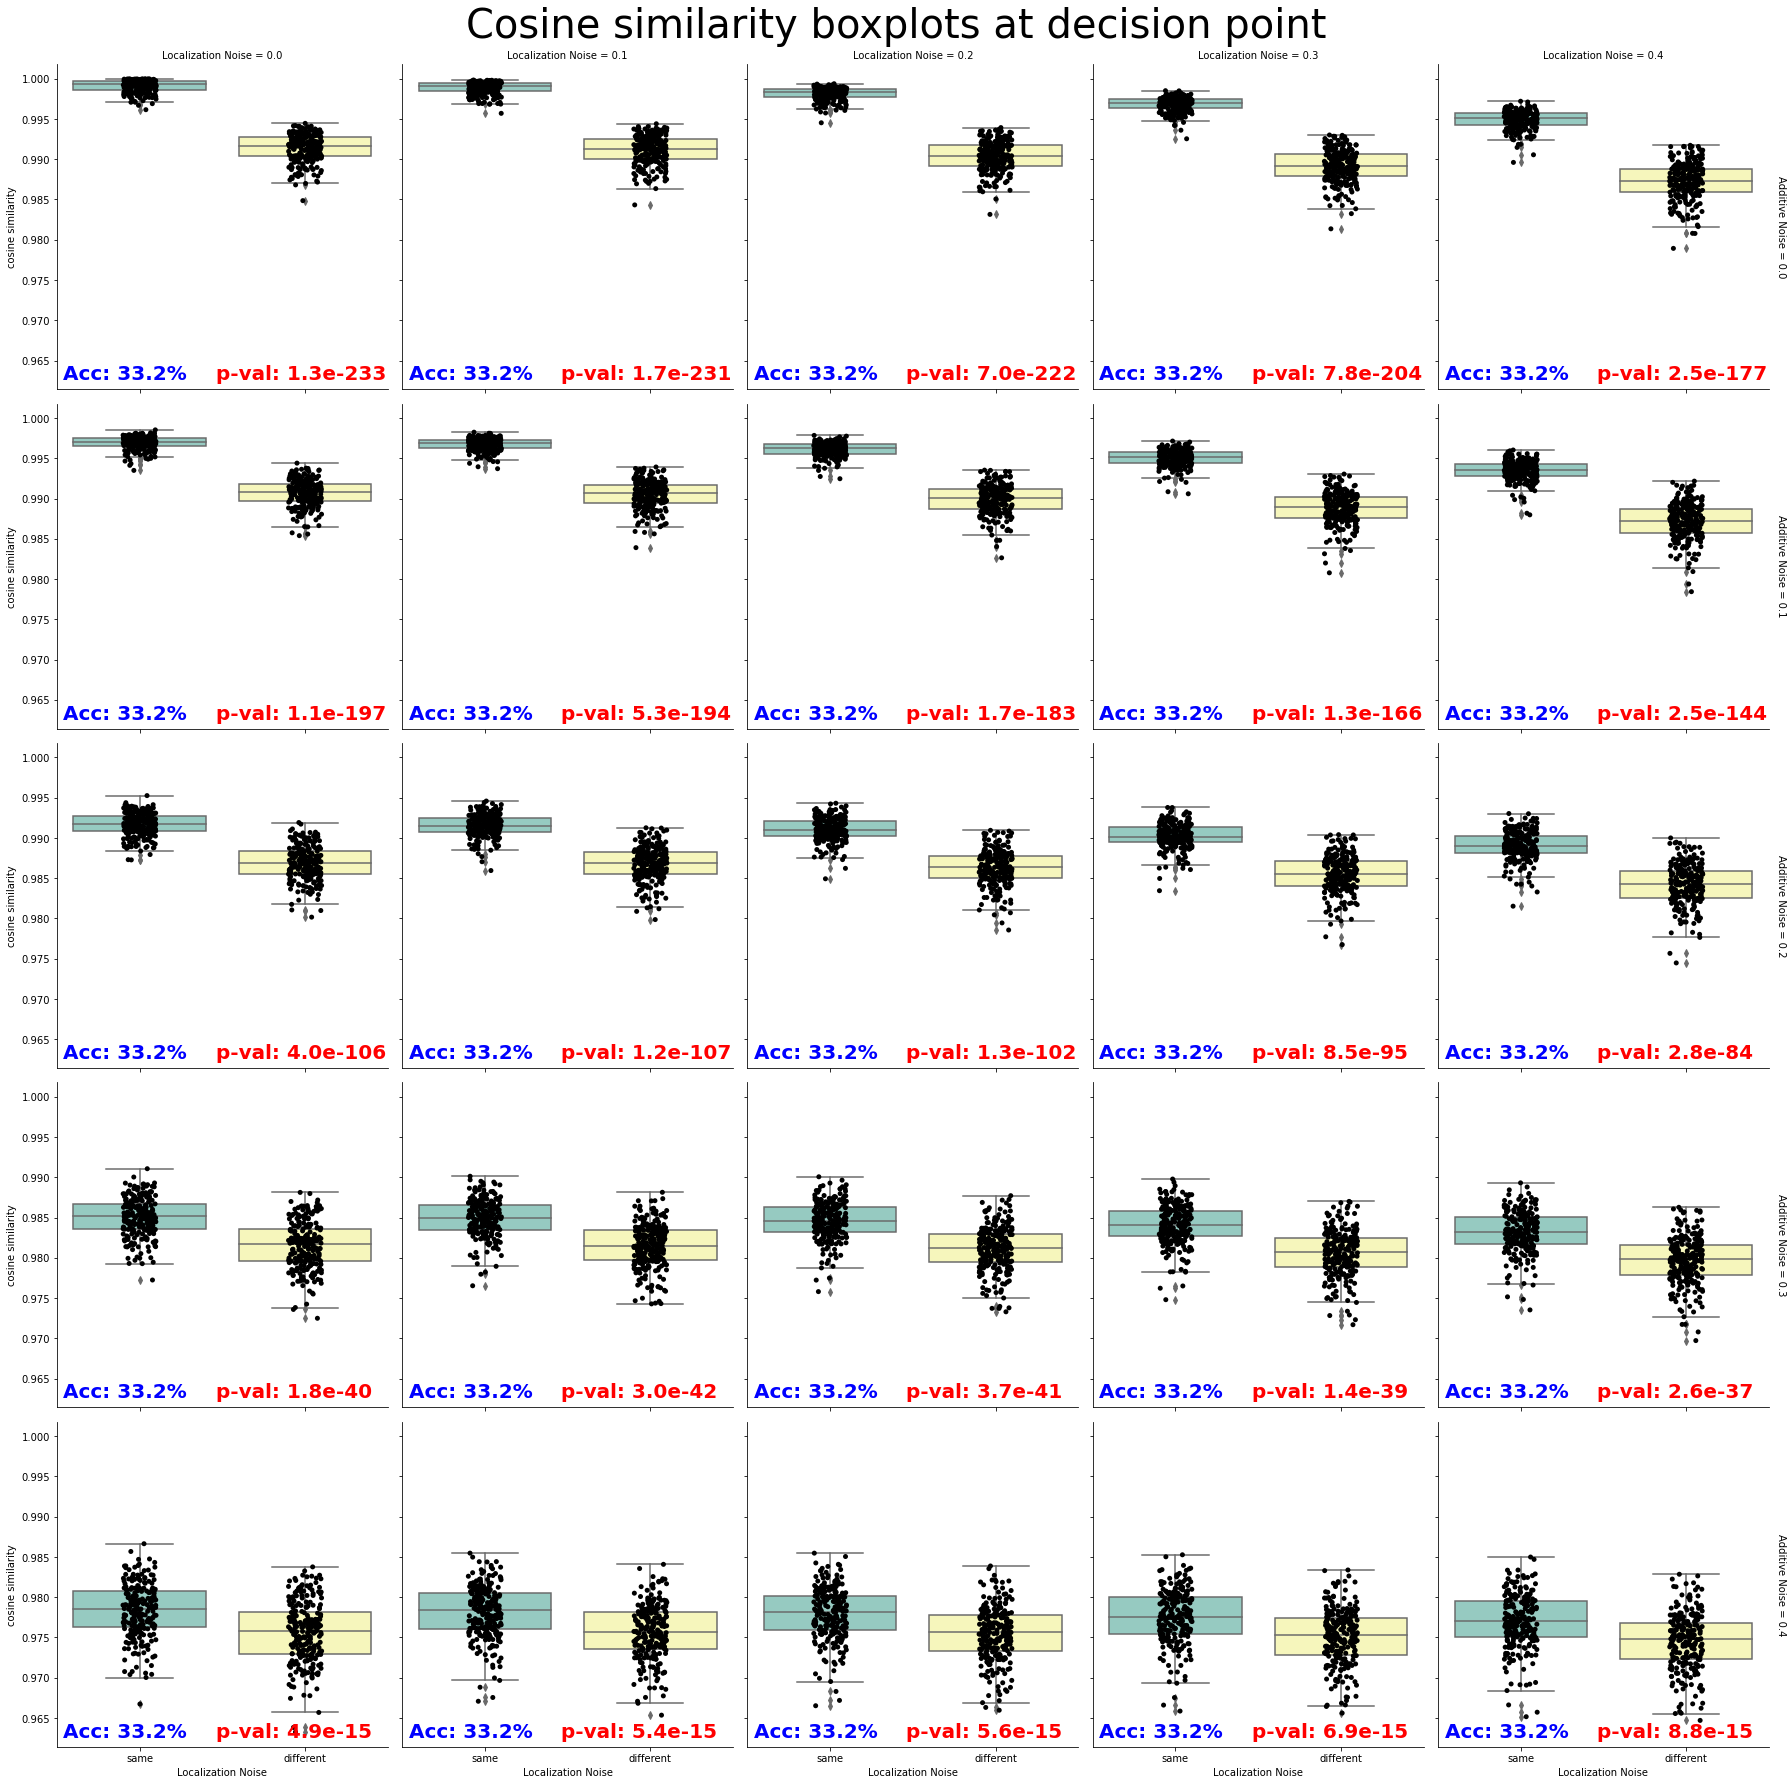

In [13]:
col1 = 'Same class distances'
col2 = 'Different class distances'
from scipy import stats

row = None
def create_distance_df(row):
    return pd.DataFrame({'Localization Noise':row["Localization Noise"], 'Additive Noise':row["Additive Noise"], 'class':np.repeat(['same','different'],len(row[col1])),'distance':row[col1] + row[col2]})

distance_df = pd.concat( [ create_distance_df(row) for key, row in noise_results.iterrows() ] ).reset_index(drop=True)

def apply_ttest(data):
    group1 = data.distance[data['class'] == 'same']
    group2 = data.distance[data['class'] == 'different']
    t_res = pg.ttest(group1, group2, paired = False)
    return t_res
  
distance_ttests = distance_df.groupby(['Localization Noise', 'Additive Noise']).apply( apply_ttest )


def stat_annotator(x, y, **kwargs):
    pval = distance_ttests.loc[x.iloc[0],y.iloc[0]]['p-val'].iloc[0]
    axes = plt.gca()
    axes.text(0.48, 0.03, f'p-val: {pval:0.1e}', transform=axes.transAxes, size=20, weight='bold', color='red')
    axes.text(0.02, 0.03, f'Acc: {33.22:0.1f}%', transform=axes.transAxes, size=20, weight='bold', color='blue')

fig_size = 5
g = sns.FacetGrid(distance_df, col="Localization Noise", row="Additive Noise", margin_titles=True, height=fig_size, aspect=1)
g.map(sns.boxplot, "class", "distance", palette="Set3" )
g.map(sns.stripplot, "class", "distance", color = 'black')
g.map(stat_annotator, "Localization Noise", "Additive Noise")
      
g.fig.suptitle('Cosine similarity boxplots at decision point', fontsize=40, y =0.99)
g.set_ylabels("cosine similarity")
g.fig.tight_layout()
plt.savefig(folder_noise + f'Similarity boxplots.png')

## Speed analysis

58.0

<AxesSubplot:ylabel='Frequency'>

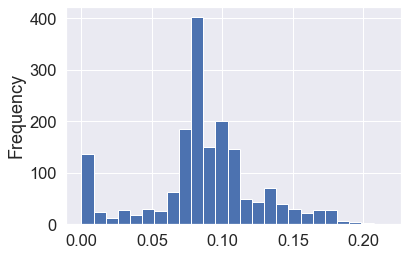

In [205]:
single_step_distances = []

def get_single_step_distances(path):
    xy = path[['x','y']]
    ends = xy[1:].copy().reset_index(drop=True)
    starts = xy[:-1].copy().reset_index(drop=True)
    dx = ends - starts
    d = np.sqrt((dx * dx).sum(axis=1))
    
    t = path[['t']]
    dt = t[1:].copy().reset_index(drop=True) - t[:-1].copy().reset_index(drop=True)
    return d / dt.t

#display(experiment_paths)
single_step_distances = pd.concat([ get_single_step_distances(path)  for rat, rat_paths in experiment_paths.items() for seq_name, path in rat_paths.items() ] ).reset_index(drop=True)

# display average number of points per trajectory
display(len(single_step_distances) / 30)
display(single_step_distances.plot.hist(bins=25))





# NOISY SEQUENCE GRAPHICS GENERATION

In [15]:
folder_noise = 'images/noise/'
folder_noisy_sequence = folder_noise + 'noisy sequence comparison/'

def get_robot_paths(results, seq):
    return [filter_path_to_decision_point(row) for key , row in results.iterrows() if row['sequence_type'] == seq]

def get_paths(tags):
    return [paths[t] for t in tags]

# PATHS for experiment 1 (synthetic sfs sfs):
paths_e1 = { 'a': get_paths(['syn-fss']), 'b':  get_paths(['syn-sfs']) , 'model': 'Reservoir', 'ltag':'FSS', 'rtag':'SFS', 'replications':40, 'name':'synth', 'folder':folder_noisy_sequence + 'synth/'} 

# PATHS for experiment 2 (robot):
paths_e2 ={ 'a':get_robot_paths(results, 'fss'), 'b':  get_robot_paths(results, 'sfs'), 'model': 'Reservoir' , 'ltag':'FSS', 'rtag':'SFS', 'replications':4, 'name':'robot', 'folder': folder_noisy_sequence + 'robot/'}

# PATHS for experiment 3 (linear regression model) 
paths_e3 ={ 'a': get_paths(['syn-fss']), 'b':  get_paths(['syn-sfs']), 'model': 'Integrator' , 'ltag':'FSS', 'rtag':'SFS', 'replications':40, 'name':'synth', 'folder': folder_noisy_sequence + 'integrator/'}

# PATHS for experiment 4: (redo experiment 1 but comparing same sequence fss and fss)
paths_e4 = { 'a': get_paths(['syn-fss']), 'b':  get_paths(['syn-fss']), 'model': 'Reservoir' , 'ltag':'FSS', 'rtag':'FSS', 'replications':40, 'name':'synth-same', 'folder': folder_noisy_sequence + 'same_sequence/'}



def get_input_and_reservoir_states( path, pcs, localization_noise, additive_noise, seed_reservoir, seed_noise):
    np.random.seed(seed_noise)
    activations = calc_activation_matrix(path, pcs, localization_noise, 0, additive_noise)

    np.random.seed(seed_reservoir)
    reservoir = PredictionESN(n_input=256, n_output=1, n_reservoir=400,  leakingRate=0.05, regressionParameters=[1e-2], solver="lsqr", feedback=False)
    reservoir.propagate(initialization_set.T) # move reservoir state away from 0 set
    return  activations, reservoir.propagate(activations.T)[257:,].T


def get_input_and_integrator_states( path, pcs, localization_noise, additive_noise, seed_reservoir, seed_noise):
    np.random.seed(seed_noise)
    activations = calc_activation_matrix(path, pcs, localization_noise, 0, additive_noise)
    
    return  activations, linear_integrator_states(activations.T, 0.95, 1.05)

choose_model = {'reservoir': get_input_and_reservoir_states, 'integrator' : get_input_and_integrator_states }

def get_similitude_df(pcs, id, pa, pb, sr, sa, sb, localization_noise, additive_noise, model):
    fun = choose_model[model.lower()]
    activations_a, states_a = fun(pa, pcs, localization_noise, additive_noise, sr, sa)
    activations_b, states_b = fun(pb, pcs, localization_noise, additive_noise, sr, sb)

    input_cos = all_cos_states(activations_a.T, activations_b.T)
    reservoir_cos = all_cos_states(states_a, states_b)
    
    points = len(input_cos)
    similitude_df = pd.DataFrame({'trial':id, 'time' : np.arange(points), 'input similitude': input_cos, 'state similitude': reservoir_cos})
    return similitude_df, activations_a, activations_b, states_a, states_b

def get_noisy_similitudes(pcs, paths_a, paths_b, replications, localization_noise, additive_noise, model):
    num_comparisons = len(paths_a) * replications
    seeds_res = np.random.randint(0, 32000, num_comparisons)
    seeds_a = np.random.randint(0, 32000, num_comparisons)
    seeds_b = np.random.randint(0, 32000, num_comparisons)
    
    # get sample
    _ , activations_a, activations_b, states_a, states_b = get_similitude_df(pcs, 0, paths_a[0], paths_b[0], seeds_res[0], seeds_a[0], seeds_b[0], localization_noise, additive_noise, model)
    all_results = pd.concat([ get_similitude_df(pcs, id, pa, pb, sr, sa, sb, localization_noise, additive_noise, model)[0] \
                             for id, pa, pb, sr, sa, sb in zip(range(num_comparisons), paths_a*replications, paths_b*replications, seeds_res, seeds_a, seeds_b )]).reset_index(drop=True)
    
    return all_results, activations_a, activations_b, states_a, states_b
        

def plot_article_figure_with_error_bands( a_left, a_right, states_a, states_b, similitudes, left_tag, right_tag , model, file_name, output_folder):
    """
        Generates a plot with 6 subplots
    """
    
    fig= plt.figure(figsize=(10,10))
    #fig.suptitle(f'Sequences: {left_tag} VS {right_tag}')


    plt.subplot(321)
    plt.title(f'A. {left_tag} Place Cell Vectors')
    sns.heatmap(a_left, vmin=0, vmax=1)
    
    plt.subplot(323)
    plt.title(f'C. {right_tag} Place Cell Vectors')
    sns.heatmap(a_right, vmin=0, vmax=1)
   

    limits = [-1, 1] if model.lower() == 'reservoir' else [0, None]
    plt.subplot(322)
    plt.title(f'B. {left_tag} {model} Activation')
    plt.plot( states_a[:,:20])
    plt.ylim(limits)

    plt.subplot(324)
    plt.title(f'B. {right_tag} {model} Activation')
    plt.plot(states_b[:,:20])
    plt.ylim(limits)
    
    plt.subplot(325)
    plt.title(f'E. {left_tag}/{right_tag} Similarity')
    ax = sns.lineplot(x="time", y="input similitude",  data = similitudes, ci='sd')
    ax.set(ylim=(0, 1.05))
    

    plt.subplot(326)
    plt.title(f'F. {left_tag}/{right_tag} {model} Similarity')
    ax = sns.lineplot(x="time", y="state similitude",  data = similitudes, ci='sd')
    # ax.set(ylim=(None, 1.01))

    fig.tight_layout()
    # plt.savefig(output_folder + file_name)
    return fig
    
palce_cells = load_place_cells('input/placecells.csv')        
nrange = 5

# pset = paths_e2
for pset in [paths_e4 ]: # paths_e3 , paths_e1 , paths_e2 ]:
    model = pset['model']
    left_tag = pset['ltag']
    right_tag = pset['rtag']
    replications = pset['replications']
    name = pset['name']
    e_folder = pset['folder']
    make_dirs(e_folder)


    all_noisy_similitudes = []      
    for localization_noise in [0.1*i for i in range(nrange)]:
        for additive_noise in [0.1*i for i in range(nrange)]:
            display(f'Noise levels: L {localization_noise} A {additive_noise}')
            noisy_similitudes, activations_a, activations_b, states_a, states_b = get_noisy_similitudes(palce_cells, pset['a'], pset['b'], replications, localization_noise, additive_noise, model)
            save_name = f'noisy_sequence_comparison {name} {left_tag} {right_tag} L{localization_noise:.1f} A{additive_noise:.1f}.png'
            fig = plot_article_figure_with_error_bands( activations_a, activations_b, states_a, states_b, noisy_similitudes, left_tag, right_tag , model,save_name ,e_folder)
            display(fig)

            noisy_similitudes['localization noise'] = f'{localization_noise:.1f}'
            noisy_similitudes['additive noise'] = f'{additive_noise:.1f}'
            all_noisy_similitudes += [noisy_similitudes]


    all_noisy_similitudes = pd.concat(all_noisy_similitudes)
    
    all_noisy_similitudes.to_pickle(folder_noise + f'all_noisy_similitudes {name} {model}.pickle')

    fig_size = 5
    g = sns.FacetGrid(all_noisy_similitudes, col="localization noise", row="additive noise", margin_titles=True, height=fig_size, aspect=1)
    g.map(sns.lineplot, "time", "state similitude" , ci='sd')
    g.fig.suptitle(f'{model} similarity series {left_tag} {right_tag}', size=40, y =0.99)
    g.fig.tight_layout()
    plt.savefig(folder_noise + f'Similarity series {model} {name} {left_tag} {right_tag}.png')


    g = sns.FacetGrid(all_noisy_similitudes, col="localization noise", row="additive noise", margin_titles=True, height=fig_size, aspect=1)
    g.map(sns.lineplot, "time", "input similitude", ci='sd' )
    g.fig.suptitle(f'Input similarity series {left_tag} {right_tag}', size=40, y =0.99 )
    g.fig.tight_layout()
    plt.savefig(folder_noise + f'Similarity series Input {model} {name} {left_tag} {right_tag}.png')


'Noise levels: L 0.0 A 0.0'

KeyboardInterrupt: 

# MIXED SELECTIVITY TESTING WITH NOISE

## Create noisy paths and models

In [188]:
import functools

# PARAMETERS:
np.random.seed(85) 
num_models = 2 # number of instances of each model type
num_rats = 2 # number of rats for each trajectory
nrange_min = 0 # noise range min value (included)
nrange_max = 2 # noise range max_value (excluded)
noise_levels = [f'{0.1*i:.1f}' for i in range(nrange_min, nrange_max)]


# GET SEQUENCES AND ACTIVATIONS WITHOUT NOISE
sequences = ['syn-fs-fs-fs', 'syn-sf-sf-fs' , 'syn-mm-mm-mm']
s_names = ['fs-fs-fs', 'sf-sf-fs', 'mm-mm-mm']
s_paths = [paths[s] for s in sequences] 
s_activations = [ activations[s] for s in sequences]
position_ids = [ 14, 28, 42] # positions where mixed selectivity will be tested
name_2_path = {s:p for s, p in zip(s_names, s_paths)}
name_2_activations = {s:a for s, a in zip(s_names, s_activations)}

# GENERATE TABLE OF NOISY ACTIVATIONS:
place_cells = load_place_cells('input/placecells.csv')

def get_rat_activations(row, pcs):
    s_name = row['sequence']
    path = name_2_path[s_name]
    no_noise = name_2_activations[s_name]

    l_noise = float(row['localization noise'])
    a_noise = float(row['additive noise'])
    n_activations = calc_activation_matrix(path, pcs, l_noise, 0, a_noise)
    n_activations[:, position_ids] = no_noise[:, position_ids]
    return n_activations
    
noisy_activations = generate_cartesian_product_table( ['localization noise', 'additive noise', 'sequence', 'rat'], [noise_levels, noise_levels, s_names, np.arange(num_rats)])
noisy_activations['activations'] = [ get_rat_activations(row, place_cells) for _ , row in noisy_activations.iterrows() ]
display(Markdown('### Noisy activations'),noisy_activations)



# CREATE MODELS TO BE TESTED
np.random.seed(1024)
num_neurons = len(place_cells)
reservoirs = [ PredictionESN(n_input=256, n_output=1, n_reservoir=256, leakingRate=0.05, regressionParameters=[1e-2], solver="lsqr", feedback=False) for i in range(num_models) ]
for r in reservoirs:
    r.propagate(initialization_set.T) # move reservoir state away from 0 set
reservoir_models = [lambda x : r.propagate(x.T)[257:,].T for r in reservoirs]

# create linear integrator models
leak_rates = [ np.random.uniform(0, 0.1, num_neurons) for i in range(num_models) ]
integrators = [ lambda x :  linear_integrator_states(x.T, 1 - rates, 1 + rates) for rates in leak_rates ]


models = generate_cartesian_product_table(['model','m_id'], [['reservoir', 'integrator'], np.arange(num_models)])
models['fun'] = reservoir_models + integrators
display(Markdown('### Models'), models)




### Noisy activations

,localization noise,additive noise,sequence,rat,activations
0,0.0,0.0,fs-fs-fs,0,"[[0.7335044614184573, 0.4523046627561055, 0.22..."
1,0.0,0.0,fs-fs-fs,1,"[[0.7335044614184573, 0.4523046627561055, 0.22..."
2,0.0,0.0,sf-sf-fs,0,"[[0.7335044614184573, 0.5763894423028244, 0.42..."
3,0.0,0.0,sf-sf-fs,1,"[[0.7335044614184573, 0.5763894423028244, 0.42..."
4,0.0,0.0,mm-mm-mm,0,"[[0.7335044614184573, 0.5312656718208043, 0.34..."
5,0.0,0.0,mm-mm-mm,1,"[[0.7335044614184573, 0.5312656718208043, 0.34..."
6,0.0,0.1,fs-fs-fs,0,"[[0.7575792243291085, 0.4540952764851869, 0.18..."
7,0.0,0.1,fs-fs-fs,1,"[[0.8242363199912581, 0.3655661892259035, 0.21..."
8,0.0,0.1,sf-sf-fs,0,"[[0.780153984221027, 0.5311619451207316, 0.462..."
9,0.0,0.1,sf-sf-fs,1,"[[0.8248568529908148, 0.5311357221438536, 0.50..."


### Models

,model,m_id,fun
0,reservoir,0,<function <listcomp>.<lambda> at 0x000001337F5...
1,reservoir,1,<function <listcomp>.<lambda> at 0x000001337F5...
2,integrator,0,<function <listcomp>.<lambda> at 0x000001337F6...
3,integrator,1,<function <listcomp>.<lambda> at 0x000001337F6...


## Fill anova table for each noise level and each model

In [189]:
# GENERATE TABLE FOR ANOVA AND MODEL RESULTS
# anova: localization noise / additive noise / model /  sequence / rat / position / speed / cell1 / ... / celln
def get_speed(row):
    seq = row['sequence']
    pos = row['position']
    if seq == 'fs-fs-fs':
        return 'slow'
    if seq == 'mm-mm-mm':
        return 'med'
    if seq == 'sf-sf-fs':
        if pos <=28:
            return 'slow'
        else:
            return 'fast'
        
anova_table = generate_cartesian_product_table(['sequence', 'rat', 'position'] , [s_names, np.arange(num_rats), position_ids] )
anova_table['speed'] = [ get_speed(row) for _,row in anova_table.iterrows() ]

# Create function to get full anova for one model and given paths
cell_columns = [f'cell_{i}' for i in range(num_neurons)]
def get_full_anova(model_data, path_data):
    model_fun = model_data['fun']
    model_activations = np.concatenate( [ model_fun( path['activations'] )[position_ids,:] for _, path in path_data.iterrows() ] ) 
    return pd.concat( [anova_table, pd.DataFrame( columns = cell_columns, data = model_activations )] , axis = 1)


all_anova_tables = pd.DataFrame( columns = ['localization noise','additive noise', 'model', 'm_id', 'anova_table'],
    data = [ [ l_noise, a_noise, model['model'], model['m_id'], get_full_anova(model, p_data) ]
              for (l_noise, a_noise), p_data in noisy_activations.groupby(['localization noise','additive noise'])
              for _ , model in models.iterrows()
    ]
)

display(all_anova_tables)            
display(all_anova_tables.iloc[0]['anova_table'])
all_anova_tables.to_pickle('all_anova_tables.pickle')


,localization noise,additive noise,model,m_id,anova_table
0,0.0,0.0,reservoir,0,sequence rat position speed cell_0 ...
1,0.0,0.0,reservoir,1,sequence rat position speed cell_0 ...
2,0.0,0.0,integrator,0,sequence rat position speed cell_0 ...
3,0.0,0.0,integrator,1,sequence rat position speed cell_0 ...
4,0.0,0.1,reservoir,0,sequence rat position speed cell_0 ...
5,0.0,0.1,reservoir,1,sequence rat position speed cell_0 ...
6,0.0,0.1,integrator,0,sequence rat position speed cell_0 ...
7,0.0,0.1,integrator,1,sequence rat position speed cell_0 ...
8,0.1,0.0,reservoir,0,sequence rat position speed cell_0 ...
9,0.1,0.0,reservoir,1,sequence rat position speed cell_0 ...


,sequence,rat,position,speed,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,...,cell_246,cell_247,cell_248,cell_249,cell_250,cell_251,cell_252,cell_253,cell_254,cell_255
0,fs-fs-fs,0,14,slow,-0.171012,-0.734323,-0.300932,0.729350,0.206995,-0.649187,...,-0.124550,0.545907,-0.713419,0.118269,0.385511,0.225164,0.167589,0.759307,0.001262,0.102979
1,fs-fs-fs,0,28,slow,-0.227462,-0.629831,-0.458179,0.768414,0.406782,-0.485774,...,-0.311949,0.346647,-0.725957,0.408964,0.204637,0.276982,0.212986,0.523396,0.153333,0.101683
2,fs-fs-fs,0,42,slow,-0.349471,-0.438508,-0.489299,0.849456,0.664573,-0.572111,...,-0.317735,0.519464,-0.603163,0.400899,0.231549,0.110813,0.061457,0.634920,-0.154390,0.168411
3,fs-fs-fs,1,14,slow,-0.198053,-0.721917,-0.296799,0.741614,0.253289,-0.702006,...,-0.133023,0.575547,-0.758761,0.078050,0.439968,0.080065,0.197903,0.764655,-0.096417,0.126893
4,fs-fs-fs,1,28,slow,-0.259491,-0.636359,-0.429237,0.772894,0.442105,-0.496318,...,-0.311534,0.350919,-0.749971,0.375924,0.214668,0.182739,0.243408,0.545428,0.103034,0.086124
5,fs-fs-fs,1,42,slow,-0.377431,-0.450994,-0.449927,0.851332,0.686167,-0.570923,...,-0.312596,0.520257,-0.602744,0.373631,0.225419,0.058399,0.086880,0.651593,-0.182630,0.147398
6,sf-sf-fs,0,14,slow,-0.120701,-0.724056,-0.224011,0.789513,0.331610,-0.676300,...,-0.013898,0.516396,-0.749703,0.034951,0.363806,-0.022730,0.061778,0.767380,-0.110732,0.173533
7,sf-sf-fs,0,28,slow,-0.132683,-0.642757,-0.372009,0.776304,0.450210,-0.406982,...,-0.268783,0.372049,-0.726141,0.311247,0.105852,0.113848,0.272196,0.543340,0.143580,0.138799
8,sf-sf-fs,0,42,fast,-0.328346,-0.450692,-0.427609,0.853050,0.694242,-0.529889,...,-0.307392,0.528728,-0.610798,0.341154,0.136192,0.040223,0.104218,0.635454,-0.158908,0.167316
9,sf-sf-fs,1,14,slow,-0.102105,-0.723627,-0.214838,0.791402,0.359810,-0.655941,...,-0.017725,0.519903,-0.757675,0.021994,0.296513,-0.022328,0.064503,0.754593,-0.094411,0.175341


In [227]:
folder_mixed_selectivity = 'images/noise/mixed_selectivity/'
make_dirs(folder_mixed_selectivity)

all_anova_tables = pd.read_pickle('all_anova_tables.pickle')

# define function to detect if a cell is a shape changer
def shape_code(e, m, l):
    # bit2 is 1 if e > m,  bit1 is 1 if m>l and bit0 is 1 if e>l, otherwise bits are 0 
    return ((e > m) << 2)  + ((m > l) << 1) + (e > l)

def is_shape_changer(mean_firing):
    # display(mean_firing)
    ef = mean_firing.loc['fs-fs-fs',14] # earl fss
    mf = mean_firing.loc['fs-fs-fs',28] # medium fss
    lf = mean_firing.loc['fs-fs-fs',42] # late fss
    es = mean_firing.loc['sf-sf-fs',14] # early sfs
    ms = mean_firing.loc['sf-sf-fs',28] # mid sfs
    ls = mean_firing.loc['sf-sf-fs',42] # late sfs
    em = mean_firing.loc['mm-mm-mm',14] # early mmm
    mm = mean_firing.loc['mm-mm-mm',28] # mid mmm
    lm = mean_firing.loc['mm-mm-mm',42] # late mmm
    
    # create string to identify order in sequence fss
    test_fss = shape_code(ef, mf, lf)
    test_sfs = shape_code(es, ms, ls)
    test_mmm = shape_code(em, mm, lm)
    

    response = 1 if (test_fss != test_sfs or test_fss != test_mmm) else 0
    # if response == 1:
    # display(f'codes: {test_fss} {test_sfs} {test_mmm}')

    return response


def process_neurons(anova_table):
    p_count=0   # number of neurons with position effect
    s_count=0   # number of neurons with speed effect
    ps_count=0  # number of neurons with position and speed effect
    # sc_count=0  # number of neurons with shape change
    shape_changers = []
    
    num_neurons = sample_anova_table.shape[1] - 4 # all but 4 columns represent neuron activities
    mean_firing = sample_anova_table.groupby(['sequence','position'])[cell_columns].mean()
    
    # display(mean_firing)
    
    sign = 0.01
    factor ='p-unc'#'p-GG-corr'#
    for neuron in cell_columns:
        res = pg.anova(dv=neuron, between=['position', 'sequence'], data=anova_table, detailed=True)
        if res.loc[0,factor] < sign:
            p_count += 1

        if res.loc[1,factor] < sign:
            s_count += 1

        if res.loc[2,factor] < sign:
            ps_count += 1  
            if is_shape_changer(mean_firing[neuron]):
                shape_changers.append(neuron)

        #if res.loc[0,factor] < sign and res.loc[1,factor] < sign and np.mean(stat_data[neuron,:]) > 0:
            #print("Two way main effect neuron: ", neuron)
    # print(factor, sign)
    # print("position effect    : ",p_count)       
    # print("sequence effec    t: ",s_count)       
    # print("pos*seq interaction: ",ps_count)    
    # print("shape changer      : ",len(shape_changers))
    return p_count, s_count, ps_count, len(shape_changers), shape_changers


all_results = []

# for noise level and model
for index, row in all_anova_tables.iterrows(): 

    l_noise    = row['localization noise']
    a_noise    = row['additive noise']
    model_name = row['model']
    model_id   = row['m_id']
    r_anova_table = row['anova_table']

    if model_id == 0:
        display(f'Plotting cells for {model_name} L{l_noise} A{a_noise}...')

        folder_cells = folder_mixed_selectivity + f'neurons/L{l_noise}_A{a_noise}/{model_name}_{model_id}/'
        make_dirs(folder_cells)

        for i in range(num_neurons):
            plt.clf()
            fig = plt.figure(figsize = (10,10))
            sns.boxplot(hue="position", x="sequence", y=f'cell_{i}', data=r_anova_table, palette="Set3")
            fig.tight_layout()
            plt.savefig(folder_cells + f'mixed selectivity cell {i}.png')
            display(folder_cells + f'mixed selectivity cell {i}.png')
            plt.close(fig)

    p_count, s_count, ps_count, sc_count, shape_changers = process_neurons(r_anova_table)
    all_results.append([l_noise, a_noise, model_name, model_id, p_count, s_count, ps_count, sc_count, shape_changers])
        
all_results = pd.DataFrame(
    columns=['localization noise', 'additive noise', 'model', 'm_id', 'p_count', 's_count', 'ps_count', 'sc_count','shape_changers'] ,
    data=all_results
)

display(all_results)



OSError: [WinError 433] A device which does not exist was specified: 'images'

In [ ]:
# define function to detect if a cell is a shape changer
def shape_code(e, m, l):
    # bit2 is 1 if e > m,  bit1 is 1 if m>l and bit0 is 1 if e>l, otherwise bits are 0 
    return ((e > m) << 2)  + ((m > l) << 1) + (e > l)

def is_shape_changer(mean_firing):
    display(mean_firing)
    ef = mean_firing.loc['fs-fs-fs',14].iloc[0] # earl fss
    mf = mean_firing.loc['fs-fs-fs',28].iloc[0] # medium fss
    lf = mean_firing.loc['fs-fs-fs',42].iloc[0] # late fss
    es = mean_firing.loc['sf-sf-fs',14].iloc[0] # early sfs
    ms = mean_firing.loc['sf-sf-fs',28].iloc[0] # mid sfs
    ls = mean_firing.loc['sf-sf-fs',42].iloc[0] # late sfs
    em = mean_firing.loc['mm-mm-mm',14].iloc[0] # early mmm
    mm = mean_firing.loc['mm-mm-mm',28].iloc[0] # mid mmm
    lm = mean_firing.loc['mm-mm-mm',42].iloc[0] # late mmm
    
    # create string to identify order in sequence fss
    test_fss = shape_code(ef, mf, lf)
    test_sfs = shape_code(es, ms, ls)
    test_mmm = shape_code(em, mm, lm)
    

    response = 1 if (test_fss != test_sfs or test_fss != test_mmm) else 0
    # if response == 1:
    # display(f'codes: {test_fss} {test_sfs} {test_mmm}')

    return response


def process_neurons(anova_table):
    p_count=0   # number of neurons with position effect
    s_count=0   # number of neurons with speed effect
    ps_count=0  # number of neurons with position and speed effect
    sc_count=0  # number of neurons with shape change
    shape_changers = []
    
    num_neurons = sample_anova_table.shape[1] - 4 # all but 4 columns represent neuron activities
    mean_firing = sample_anova_table.groupby(['sequence','position'])[cell_columns].mean()
    
    sign = 0.01
    factor ='p-unc'#'p-GG-corr'#
    for neuron in cell_columns:
        res = pg.anova(dv=neuron, between=['position', 'sequence'], data=anova_table, detailed=True)
        if res.loc[0,factor] < sign:
            p_count = p_count +1

        if res.loc[1,factor] < sign:
            s_count = s_count +1

        if res.loc[2,factor] < sign:
            ps_count = ps_count +1  
            if is_shapechanger(mean_firing[neuron]):
                shape_changers += [neuron]

        #if res.loc[0,factor] < sign and res.loc[1,factor] < sign and np.mean(stat_data[neuron,:]) > 0:
            #print("Two way main effect neuron: ", neuron)
    sc_count = len(shape_changers)
    print(factor, sign)
    print("position effect    : ",p_count)       
    print("sequence effec    t: ",s_count)       
    print("pos*seq interaction: ",ps_count)    
    print("shape changer      : ",sc_count)
    return p_count, s_count, ps_count, sc_count, shape_changers
    

In [223]:
all_anova_tables

,localization noise,additive noise,model,m_id,anova_table
0,0.0,0.0,reservoir,0,sequence rat position speed cell_0 ...
1,0.0,0.0,reservoir,1,sequence rat position speed cell_0 ...
2,0.0,0.0,integrator,0,sequence rat position speed cell_0 ...
3,0.0,0.0,integrator,1,sequence rat position speed cell_0 ...
4,0.0,0.1,reservoir,0,sequence rat position speed cell_0 ...
5,0.0,0.1,reservoir,1,sequence rat position speed cell_0 ...
6,0.0,0.1,integrator,0,sequence rat position speed cell_0 ...
7,0.0,0.1,integrator,1,sequence rat position speed cell_0 ...
8,0.1,0.0,reservoir,0,sequence rat position speed cell_0 ...
9,0.1,0.0,reservoir,1,sequence rat position speed cell_0 ...
